##匯入資料

In [ ]:
# Import necessary libraries
import pandas as pd
import shap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from google.colab import files

# (Re-import for extended use)
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier  # Ensure XGBClassifier is properly imported
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Upload dataset from local machine
print("Please upload your file:")
uploaded = files.upload()

# Automatically extract the uploaded file name
file_name = list(uploaded.keys())[0]
print(f"Reading the file: {file_name}")

# Attempt to read the CSV file using ISO-8859-1 encoding
happiness_data = pd.read_csv(file_name, encoding='ISO-8859-1')

# Display the first few rows to verify successful data loading
print("Here is a preview of your data:")
print(happiness_data.head())


Please upload your file:


Saving ml_1130330 1918.csv to ml_1130330 1918.csv
Reading the file: ml_1130330 1918.csv
Here is a preview of your data:
   id_me       id  id_new  group      sendtime  smstime1  smstime2  gender  \
0      1     10.0     NaN      1  2.020000e+13       NaN       NaN       2   
1      2    100.0     NaN      1  2.020000e+13       NaN       NaN       2   
2      3  10000.0     NaN      1  2.020000e+13       NaN       NaN       1   
3      4  10003.0     NaN      1  2.020000e+13       NaN       NaN       2   
4      5  10006.0     NaN      1  2.020000e+13       NaN       NaN       1   

   v2  v53city  ...  life_purpose_z  life_goal_z  public_welfare_commitment_z  \
0  73        2  ...       -0.248517    -1.328270                    -0.723871   
1  80        4  ...       -0.248517    -1.328270                     0.524844   
2  85       14  ...        0.243869     0.325505                    -0.307633   
3  75       15  ...        0.243869    -0.501383                    -0.307633   
4  55 

In [ ]:
# Assume happiness_data is the dataset
df = happiness_data

# Define ordinal variables (to apply ordinal encoding)
ordinal_vars = ['charity_participation', 'community_improvement', 'volunteer_work', 'community_meetings',
                'social_issue_participation', 'political_activity', 'religious_donations',
                'non_religious_donations', 'helping_others', 'public_opinion_polling',
                'civic_expression', 'bmi_gp', 'income', 'educational_attainment']

# Define nominal (unordered categorical) variables (to apply one-hot encoding)
nominal_vars = ['gender', 'region', 'religion', 'nearby_cultural_sites',
                'nearby_relaxation_spots', 'traffic_safety', 'crime_safety',
                'work', 'marry', 'nearby_shops', 'nearby_transit']

# ➤ Step 1: Apply ordinal encoding
# If ordinal variables are already coded as integers in correct order, retain as-is
df[ordinal_vars] = df[ordinal_vars].astype('int')

# ➤ Step 2: Apply one-hot encoding for nominal variables
df[nominal_vars] = df[nominal_vars].astype("category")  # <<<< Critical step!
df_nominal = pd.get_dummies(df[nominal_vars], drop_first=True)

# ➤ Step 3: Combine encoded features
used_df = pd.concat([df[ordinal_vars], df_nominal], axis=1)

# ➤ Step 4: Add identifier and target variable
used_df['id_me'] = df['id_me']
used_df['SWB_category'] = df['SWB_category']

# ➤ Step 5: Preview the processed dataset
used_df.head()

# ✅ Step 6: Display all column names in used_df (including one-hot encoded variables)
print(f"✅ Total number of columns (including id_me and SWB_category): {used_df.shape[1]}")
print("📋 List of all columns in used_df:\n")

for i, col in enumerate(used_df.columns, 1):
    print(f"{i:>3}. {col}")


✅ used_df 總欄位數（包含 id_me 與 SWB_category）：31
📋 以下是 used_df 中的所有欄位名稱（包含 One-hot Encoding 結果）：

  1. charity_participation
  2. community_improvement
  3. volunteer_work
  4. community_meetings
  5. social_issue_participation
  6. political_activity
  7. religious_donations
  8. non_religious_donations
  9. helping_others
 10. public_opinion_polling
 11. civic_expression
 12. bmi_gp
 13. income
 14. educational_attainment
 15. gender_2
 16. region_2
 17. region_3
 18. region_4
 19. religion_2
 20. religion_3
 21. religion_4
 22. nearby_cultural_sites_2
 23. nearby_relaxation_spots_2
 24. traffic_safety_2
 25. crime_safety_2
 26. work_1
 27. marry_1
 28. nearby_shops_2
 29. nearby_transit_2
 30. id_me
 31. SWB_category


In [ ]:
# Upload the second CSV file (containing continuous variables)
print("Please upload the second file with continuous variables:")
uploaded_continuous = files.upload()

# Automatically retrieve the uploaded file name
file_name_continuous = list(uploaded_continuous.keys())[0]
print(f"Reading the second file: {file_name_continuous}")

# Try reading the second CSV using ISO-8859-1 encoding
continuous_data = pd.read_csv(file_name_continuous, encoding='ISO-8859-1')

# Display the first few rows to confirm successful loading
print("Here is a preview of the continuous data:")
print(continuous_data.head())  # Preview the second file


Please upload the second file with continuous variables:


Saving ml_1130330 1918.csv to ml_1130330 1918 (1).csv
Reading the second file: ml_1130330 1918 (1).csv
Here is a preview of the continuous data:
   id_me       id  id_new  group      sendtime  smstime1  smstime2  gender  \
0      1     10.0     NaN      1  2.020000e+13       NaN       NaN       2   
1      2    100.0     NaN      1  2.020000e+13       NaN       NaN       2   
2      3  10000.0     NaN      1  2.020000e+13       NaN       NaN       1   
3      4  10003.0     NaN      1  2.020000e+13       NaN       NaN       2   
4      5  10006.0     NaN      1  2.020000e+13       NaN       NaN       1   

   v2  v53city  ...  life_purpose_z  life_goal_z  public_welfare_commitment_z  \
0  73        2  ...       -0.248517    -1.328270                    -0.723871   
1  80        4  ...       -0.248517    -1.328270                     0.524844   
2  85       14  ...        0.243869     0.325505                    -0.307633   
3  75       15  ...        0.243869    -0.501383              

In [ ]:
# Merge 'used_df' and 'continuous_data' by 'id_me' (1:1 merge)
merged_data = pd.merge(used_df, continuous_data, on='id_me', how='inner')

# Display the merged dataset
print("Here is the merged data:")
print(merged_data.head())

# ✅ Print total number of columns and column names in 'merged_data'
print(f"✅ Total number of columns in merged_data: {merged_data.shape[1]}")
print("📋 Column names in merged_data:\n")

for i, col in enumerate(merged_data.columns, 1):
    print(f"{i:>3}. {col}")


Here is the merged data:
   charity_participation_x  community_improvement_x  volunteer_work_x  \
0                        1                        1                 1   
1                        3                        1                 1   
2                        2                        2                 1   
3                        2                        1                 1   
4                        1                        1                 1   

   community_meetings_x  social_issue_participation_x  political_activity_x  \
0                     1                             1                     1   
1                     1                             1                     1   
2                     1                             1                     1   
3                     1                             1                     1   
4                     1                             1                     1   

   religious_donations_x  non_religious_donations_x  helping_

#確定哪些是高度相關變項

[LightGBM] [Info] Number of positive: 4872, number of negative: 3897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1572
[LightGBM] [Info] Number of data points in the train set: 8769, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555594 -> initscore=0.223298
[LightGBM] [Info] Start training from score 0.223298


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
<ipython-input-10-1bb5fc44994a>:67: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


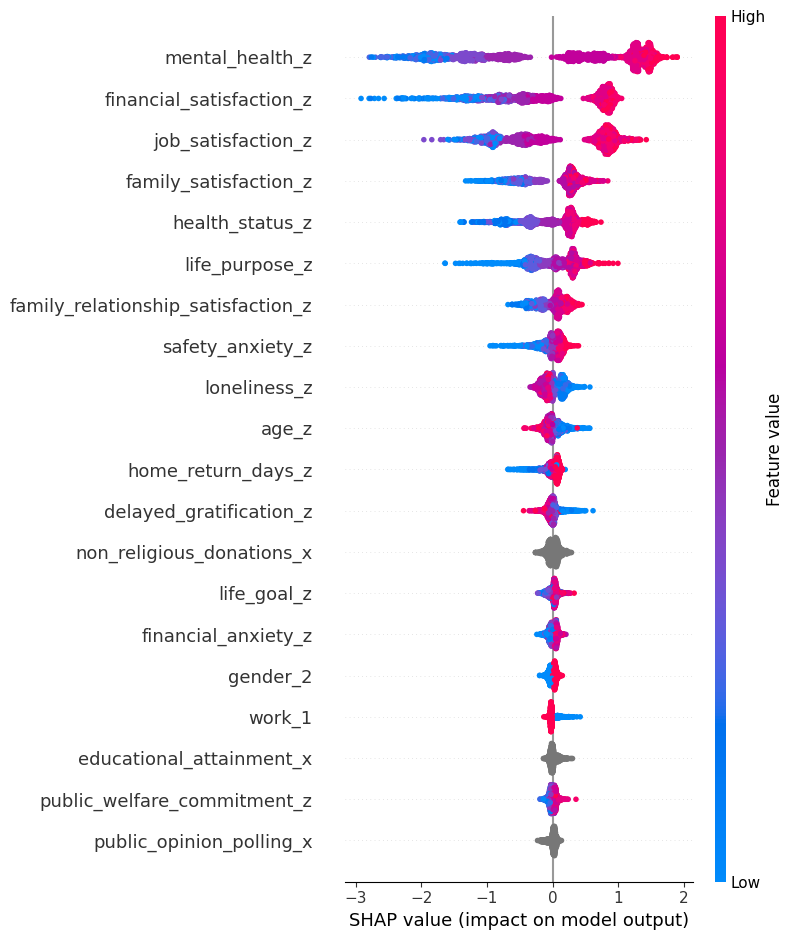

In [ ]:
# ✅ LightGBM best practice version: Native categorical feature handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import shap

# ---------- 0. Set random seed ----------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------- 1. Define variable groups ----------
# Ordinal variables (to be cast as category)
ordinal_vars = ['charity_participation_x', 'community_improvement_x', 'volunteer_work_x', 'community_meetings_x',
                'social_issue_participation_x', 'political_activity_x', 'religious_donations_x',
                'non_religious_donations_x', 'helping_others_x', 'public_opinion_polling_x',
                'civic_expression_x', 'bmi_gp_x', 'income_x', 'educational_attainment_x']

# Nominal variables (already one-hot encoded)
nominal_vars = ['gender_2', 'region_2', 'region_3', 'region_4',
                'religion_2', 'religion_3', 'religion_4',
                'nearby_shops_2', 'nearby_transit_2', 'nearby_cultural_sites_2',
                'nearby_relaxation_spots_2', 'traffic_safety_2', 'crime_safety_2',
                'work_1', 'marry_1']

# Continuous variables
continuous_vars = ['age_z', 'home_return_days_z', 'health_status_z', 'mental_health_z',
                   'job_satisfaction_z', 'family_satisfaction_z', 'relationship_satisfaction_z',
                   'financial_satisfaction_z', 'family_relationship_satisfaction_z',
                   'loneliness_z', 'life_purpose_z', 'life_goal_z',
                   'public_welfare_commitment_z', 'delayed_gratification_z',
                   'financial_anxiety_z', 'safety_anxiety_z']

# ---------- 2. Cast ordinal variables to categorical dtype ----------
for col in ordinal_vars:
    merged_data[col] = merged_data[col].astype('int').astype('category')

# ---------- 3. Define features and target ----------
X = merged_data[ordinal_vars + nominal_vars + continuous_vars]
y = merged_data['SWB_category_y']

# ---------- 4. Train-test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# ---------- 5. Apply SMOTE to balance training data ----------
smote = SMOTE(sampling_strategy=0.8, random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ---------- 6. Train LightGBM model ----------
lgbm = LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=RANDOM_SEED)
lgbm.fit(X_train_resampled, y_train_resampled)

# ---------- 7. SHAP value calculation and visualization ----------
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

# Binary classification: use SHAP values of class 1
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# SHAP summary plot for original features
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


# Baseline model

[LightGBM] [Info] Number of positive: 4310, number of negative: 5388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 9698, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444422 -> initscore=-0.223236
[LightGBM] [Info] Start training from score -0.223236


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/loc

✅ 儲存 Disparate Impact, Equal Opportunity, Equalized Odds (Before Adjustment)
[LightGBM] [Info] Number of positive: 3879, number of negative: 4849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 8728, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444432 -> initscore=-0.223195
[LightGBM] [Info] Start training from score -0.223195
[LightGBM] [Info] Number of positive: 3879, number of negative: 4849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points

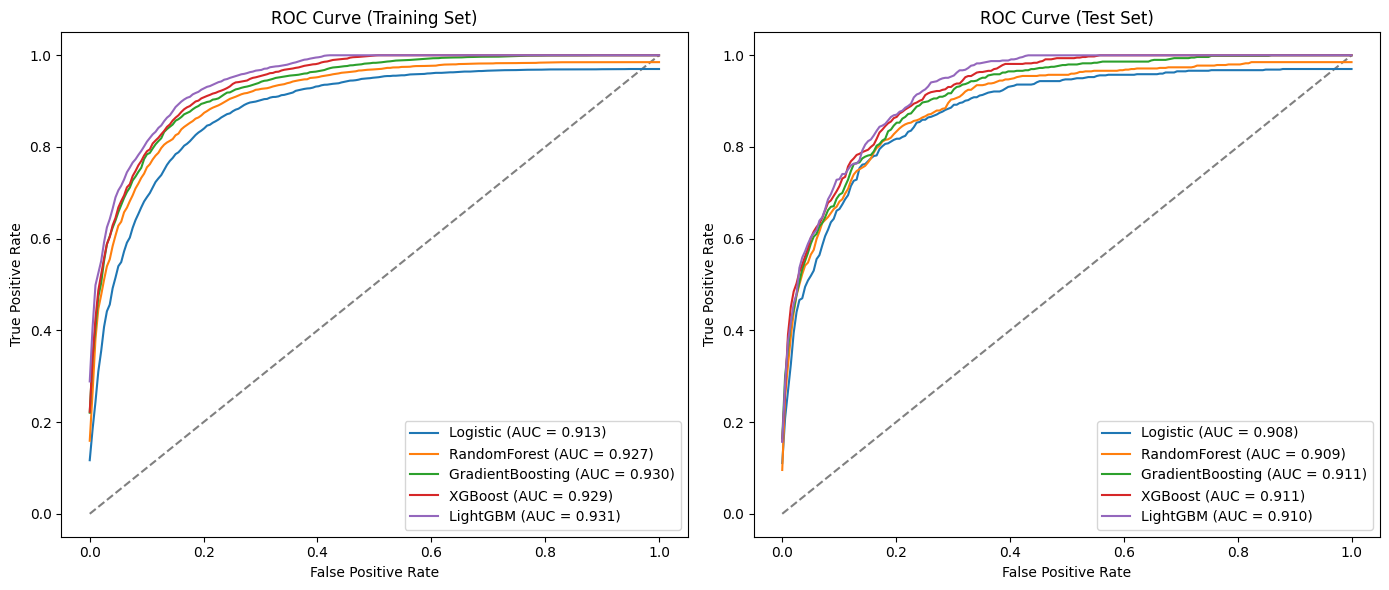

✅ 儲存 performance 指標完成


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score,
    recall_score, precision_score, f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from google.colab import files

# =======================
# 🪩 1. Variable Setup
# =======================
# Set random seed for reproducibility
RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)

# Define ordinal, nominal, and continuous variables
ordinal_vars = [
    'charity_participation_x', 'community_improvement_x', 'volunteer_work_x', 'community_meetings_x',
    'social_issue_participation_x', 'political_activity_x', 'religious_donations_x',
    'non_religious_donations_x', 'helping_others_x', 'public_opinion_polling_x',
    'civic_expression_x', 'bmi_gp_x', 'income_x', 'educational_attainment_x']

nominal_vars = [
    'gender_2', 'region_2', 'region_3', 'region_4',
    'religion_2', 'religion_3', 'religion_4',
    'nearby_shops_2', 'nearby_transit_2', 'nearby_cultural_sites_2',
    'nearby_relaxation_spots_2', 'traffic_safety_2', 'crime_safety_2',
    'work_1', 'marry_1']

continuous_vars = [
    'age_z', 'home_return_days_z', 'health_status_z',
    'relationship_satisfaction_z',
    'family_relationship_satisfaction_z', 'loneliness_z', 'life_goal_z',
    'public_welfare_commitment_z', 'delayed_gratification_z',
    'financial_anxiety_z', 'safety_anxiety_z']

# ================================
# 🪩 2. Prepare datasets
# ================================
# Create feature matrix and target variable
X_all = merged_data[ordinal_vars + nominal_vars + continuous_vars]
y = merged_data['SWB_category_y']

# For LightGBM: convert categorical features to 'category' dtype
X_lgb = X_all.copy()
X_lgb[ordinal_vars] = X_lgb[ordinal_vars].astype('category')
X_lgb[nominal_vars] = X_lgb[nominal_vars].astype('category')

# For other models: encode ordinal variables as integers
X_encoded = X_all.copy()
X_encoded[ordinal_vars] = X_encoded[ordinal_vars].astype(int)

# Train/test split
X_train_enc, X_test_enc, y_train_enc, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
X_train_lgb, X_test_lgb, y_train_lgb, _ = train_test_split(X_lgb, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

# Apply SMOTE to balance training data
X_train_enc, y_train_enc = SMOTE(sampling_strategy=0.8, random_state=RANDOM_SEED).fit_resample(X_train_enc, y_train_enc)
X_train_lgb, y_train_lgb = SMOTE(sampling_strategy=0.8, random_state=RANDOM_SEED).fit_resample(X_train_lgb, y_train_lgb)

# ============================
# 🪩 3. Define and Train Models
# ============================
# Initialize and train five models: Logistic, RF, GB, XGB, LGBM
models = {
    "Logistic": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=RANDOM_SEED),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.02, max_depth=4, min_child_weight=3, gamma=0.2, subsample=0.7, colsample_bytree=0.7, random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=RANDOM_SEED)
}

for name, model in models.items():
    if name == "LightGBM":
        model.fit(X_train_lgb, y_train_lgb)
    else:
        model.fit(X_train_enc, y_train_enc)

# ============================
# 🪩 4. Compute Fairness (Corrected, includes Disparate Impact)
# ============================
# Calculate fairness metrics across sensitive attributes
# Metrics: Disparate Impact, Equal Opportunity, Equalized Odds
fairness_before = []
sensitive_attributes = ['gender_2', 'income_x', 'educational_attainment_x']
label_name = 'SWB_category_y'

for sensitive_attr in sensitive_attributes:
    for name, model in models.items():
        if name == "LightGBM":
            y_prob = model.predict_proba(X_test_lgb)[:, 1]
            y_true = y_test.reset_index(drop=True)
            X_temp = X_test_lgb.copy()
        else:
            y_prob = model.predict_proba(X_test_enc)[:, 1]
            y_true = y_test.reset_index(drop=True)
            X_temp = X_test_enc.copy()

        X_temp[label_name] = y_true
        X_temp['score'] = y_prob
        X_temp['pred'] = (y_prob >= 0.5).astype(int)
        X_temp = X_temp.dropna()

        if sensitive_attr not in X_temp.columns:
            continue

        aif_true = BinaryLabelDataset(
            df=X_temp,
            label_names=[label_name],
            protected_attribute_names=[sensitive_attr],
            favorable_label=1,
            unfavorable_label=0
        )

        aif_pred = aif_true.copy()
        aif_pred.labels = X_temp['pred'].values.reshape(-1, 1)

        metric = ClassificationMetric(
            aif_true, aif_pred,
            unprivileged_groups=[{sensitive_attr: 0}],
            privileged_groups=[{sensitive_attr: 1}]
        )

        fairness_before.append({
            "Model": name,
            "Sensitive Attr": sensitive_attr,
            "Disparate Impact (Before)": metric.disparate_impact(),
            "Equal Opportunity (Before)": metric.equal_opportunity_difference(),
            "Equalized Odds (Before)": metric.equalized_odds_difference()
        })

fairness_before_df = pd.DataFrame(fairness_before)
fairness_before_df.to_csv("fairness_metrics_before.csv", index=False)
print("✅ Saved Disparate Impact, Equal Opportunity, Equalized Odds (Before Adjustment)")

# ============================
# 🪩 5. ROC Curve
# ============================
# Plot training and test ROC curves with AUC from 10-fold CV
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
all_fpr = np.linspace(0, 1, 200)
colors = plt.get_cmap("tab10")
offset = 0.015

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("ROC Curve (Training Set)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

for i, (name, model) in enumerate(models.items()):
    mean_tpr = np.zeros_like(all_fpr)
    auc_scores = []

    for train_idx, val_idx in kf.split(X_train_enc, y_train_enc):
        if name == "LightGBM":
            model.fit(X_train_lgb.iloc[train_idx], y_train_lgb.iloc[train_idx])
            y_pred_prob = model.predict_proba(X_train_lgb.iloc[val_idx])[:, 1]
            fpr, tpr, _ = roc_curve(y_train_lgb.iloc[val_idx], y_pred_prob)
        else:
            model.fit(X_train_enc.iloc[train_idx], y_train_enc.iloc[train_idx])
            y_pred_prob = model.predict_proba(X_train_enc.iloc[val_idx])[:, 1]
            fpr, tpr, _ = roc_curve(y_train_enc.iloc[val_idx], y_pred_prob)

        auc_scores.append(auc(fpr, tpr))
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= kf.get_n_splits()
    mean_auc = np.mean(auc_scores)
    plt.plot(all_fpr, np.clip(mean_tpr + (i - 2) * offset, 0, 1), label=f"{name} (AUC = {mean_auc:.3f})", color=colors(i))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("ROC Curve (Test Set)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

for i, (name, model) in enumerate(models.items()):
    if name == "LightGBM":
        y_pred_prob = model.predict_proba(X_test_lgb)[:, 1]
    else:
        y_pred_prob = model.predict_proba(X_test_enc)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(all_fpr, np.clip(np.interp(all_fpr, fpr, tpr) + (i - 2) * offset, 0, 1), label=f"{name} (AUC = {auc(fpr, tpr):.3f})", color=colors(i))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 🪩 6. Performance Metrics
# ============================
# Evaluate prediction performance on test data
# Metrics: Accuracy, Recall, Specificity, Precision, F1 Score, AUROC
performance_records = {
    "Model": [],
    "Accuracy": [],
    "Sensitivity (Recall)": [],
    "Specificity": [],
    "Precision": [],
    "F1 Score": [],
    "AUROC": []
}

for name, model in models.items():
    if name == "LightGBM":
        y_pred = model.predict(X_test_lgb)
        y_pred_prob = model.predict_proba(X_test_lgb)[:, 1]
    else:
        y_pred = model.predict(X_test_enc)
        y_pred_prob = model.predict_proba(X_test_enc)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    performance_records["Model"].append(name)
    performance_records["Accuracy"].append(accuracy_score(y_test, y_pred))
    performance_records["Sensitivity (Recall)"].append(recall_score(y_test, y_pred))
    performance_records["Specificity"].append(tn / (tn + fp))
    performance_records["Precision"].append(precision_score(y_test, y_pred))
    performance_records["F1 Score"].append(f1_score(y_test, y_pred))
    performance_records["AUROC"].append(roc_auc_score(y_test, y_pred_prob))

performance_df = pd.DataFrame(performance_records)
performance_df.to_csv("final_model_performance.csv", index=False)
print("✅ Saved performance metrics")

# ============================
# 🪩 7. Auto Download
# ============================
# Download result CSVs
files.download("final_model_performance.csv")
files.download("fairness_metrics_before.csv")


##SHAP

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
<ipython-input-21-f234ef636c99>:86: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)


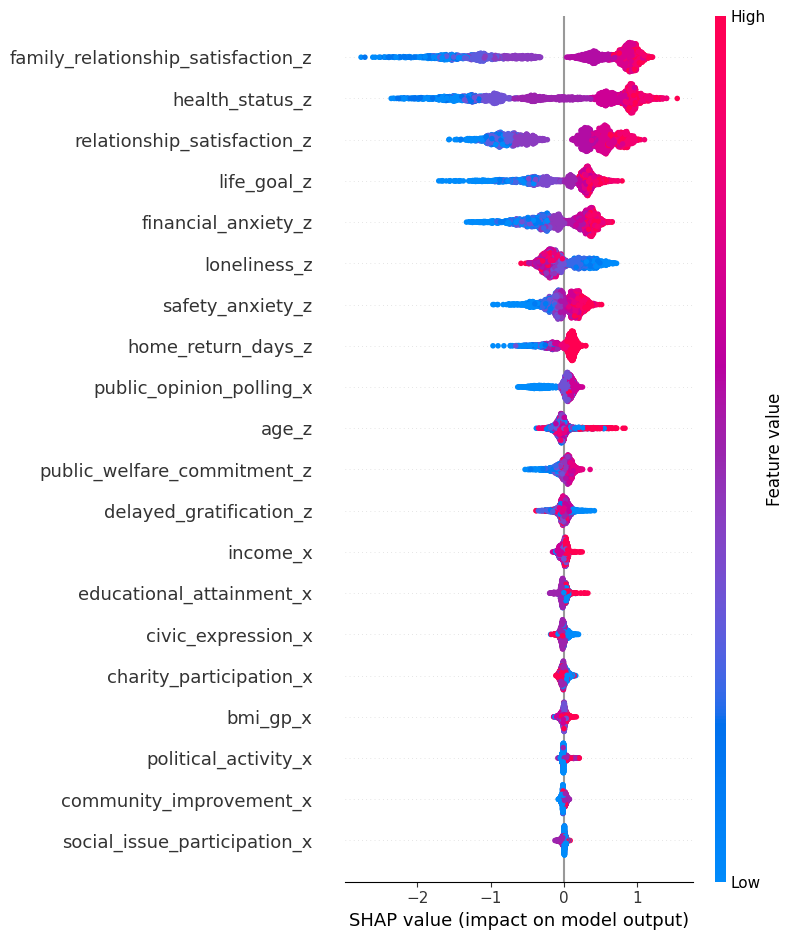

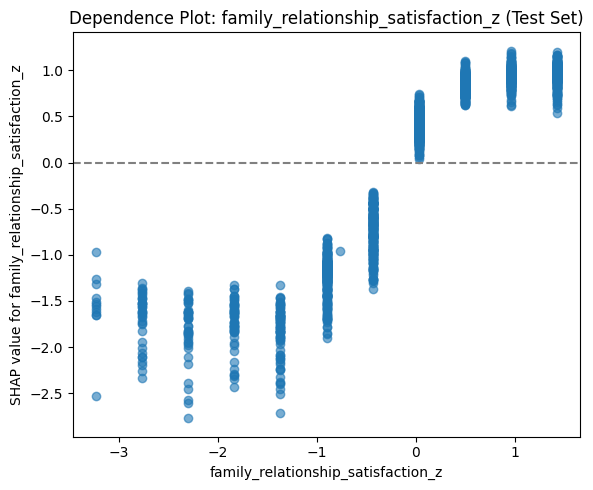

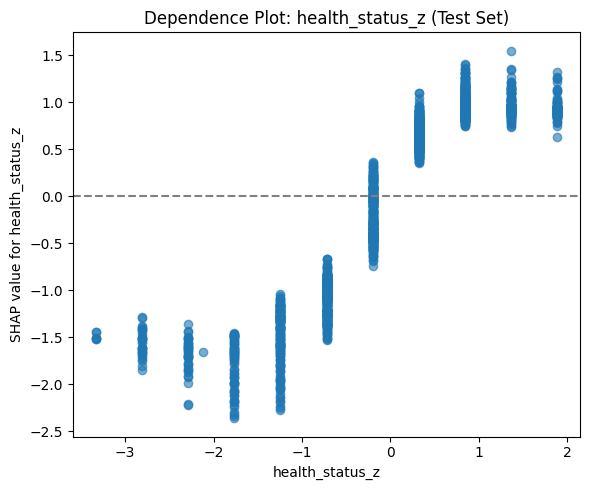

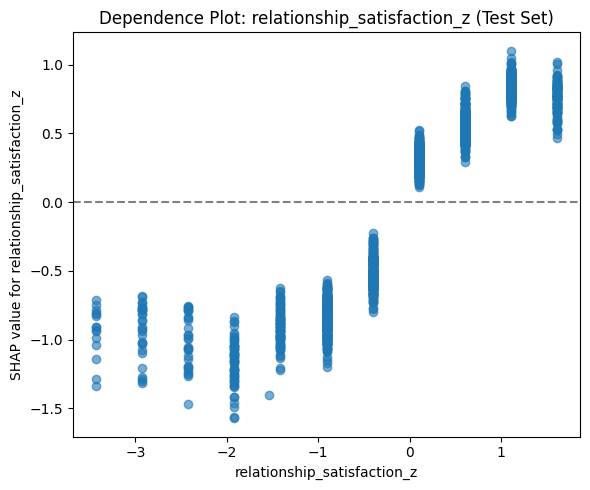

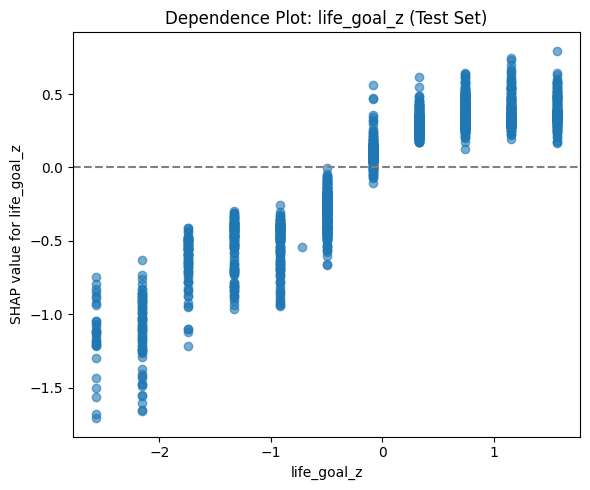

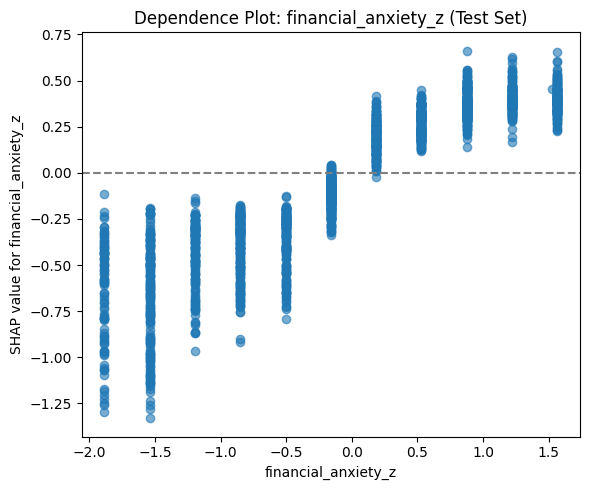

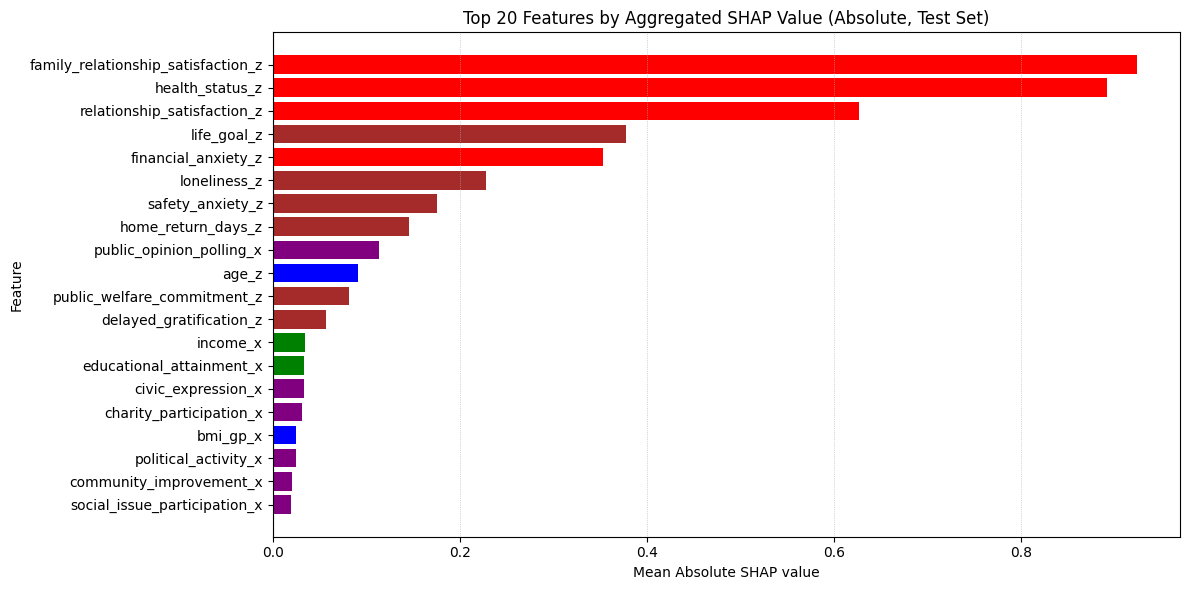

⚠️ 以下變項沒有分類（所以顯示為灰色）：



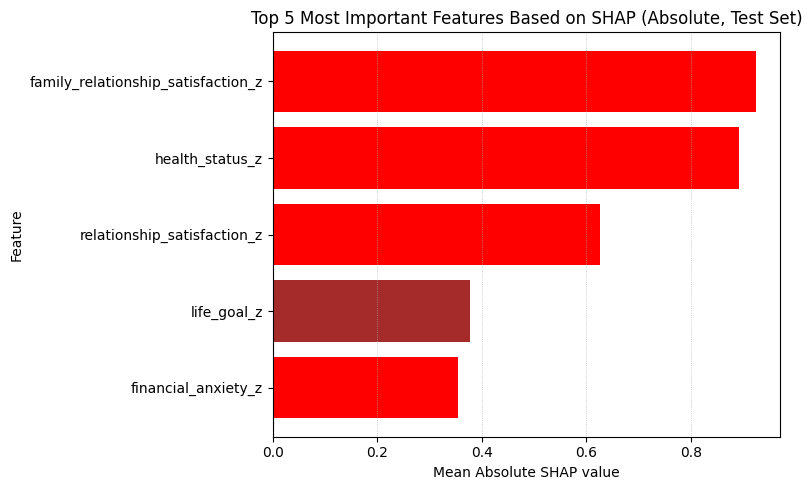

In [ ]:
# ✅ SHAP Summary Plot & Dependence Plot (for LightGBM only, using updated variable list)

import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# Define color mapping for variable categories
category_colors = {
    'Demographic Variables': 'blue',
    'Socioeconomic Variables': 'green',
    'Neighborhood Environment Variables': 'orange',
    'Social Participation Variables': 'purple',
    'Health and Satisfaction Variables': 'red',
    'Psychological and Behavioral Variables': 'brown'
}

# Define feature categories (updated to reflect all relevant features)
categories = {
    'Demographic Variables': [
        'gender', 'region', 'religion_2', 'religion_3', 'religion_4', 'age_z', 'marry', 'bmi_gp_x'
    ],
    'Socioeconomic Variables': [
        'work', 'work_1', 'income_x', 'educational_attainment_x'
    ],
    'Neighborhood Environment Variables': [
        'nearby_shops_2', 'nearby_relaxation_spots', 'traffic_safety_2',
        'crime_safety_2', 'nearby_cultural_sites', 'nearby_cultural_sites_2'
    ],
    'Social Participation Variables': [
        'charity_participation_x', 'community_improvement_x', 'volunteer_work_x',
        'community_meetings_x', 'social_issue_participation_x', 'political_activity_x',
        'religious_donations_x', 'non_religious_donations_x', 'helping_others_x',
        'public_opinion_polling_x', 'civic_expression_x'
    ],
    'Health and Satisfaction Variables': [
        'health_status_z', 'relationship_satisfaction_z', 'financial_anxiety_z',
        'family_relationship_satisfaction_z'
    ],
    'Psychological and Behavioral Variables': [
        'public_welfare_commitment_z', 'delayed_gratification_z',
        'safety_anxiety_z', 'life_goal_z', 'home_return_days_z', 'loneliness_z'
    ]
}

Baseline_LightGBM = models["LightGBM"]
explainer = shap.TreeExplainer(Baseline_LightGBM)
shap_values = explainer.shap_values(X_test_lgb)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Convert categorical variables to numeric for SHAP plotting
X_test_numeric = X_test_lgb.copy()
for col in X_test_numeric.select_dtypes(include='category').columns:
    X_test_numeric[col] = X_test_numeric[col].cat.codes

# Function for aggregating SHAP values across dummies or similar features
def aggregate_shap(shap_vals, X, feature_names, method="signed"):
    shap_df = pd.DataFrame(shap_vals, columns=feature_names)
    X_df = pd.DataFrame(X, columns=feature_names)
    base_features = {}
    for col in feature_names:
        base = re.sub(r"_\d+$", "", col)
        base_features.setdefault(base, []).append(col)

    aggregated_shap = pd.DataFrame()
    aggregated_features = pd.DataFrame()
    for base, cols in base_features.items():
        if method == "abs":
            aggregated_shap[base] = shap_df[cols].abs().mean(axis=1)
        else:
            aggregated_shap[base] = shap_df[cols].mean(axis=1)
        aggregated_features[base] = X_df[cols].mean(axis=1)

    return aggregated_shap, aggregated_features

# Aggregate SHAP values and corresponding features
shap_df_signed, X_df_signed = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="signed")

# Summary plot of SHAP values (signed)
shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)

# Dependence plots for the top 5 most influential features
top5_signed = shap_df_signed.abs().mean().sort_values(ascending=False).head(5).index.tolist()
for feature in top5_signed:
    plt.figure(figsize=(6, 5))
    plt.scatter(X_df_signed[feature], shap_df_signed[feature], alpha=0.6)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel(feature)
    plt.ylabel(f"SHAP value for {feature}")
    plt.title(f"Dependence Plot: {feature} (Test Set)")
    plt.tight_layout()
    plt.show()

# Function to retrieve color for each feature based on predefined category
def get_feature_color(f):
    for cat, vars in categories.items():
        if f in vars:
            return category_colors[cat]
    return 'gray'  # Unclassified features will appear in gray

# Bar chart showing top 20 features based on absolute SHAP value
shap_df_abs, _ = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="abs")
mean_abs_vals = shap_df_abs.mean().sort_values(ascending=False).head(20)
colors = [get_feature_color(f) for f in mean_abs_vals.index]

plt.figure(figsize=(12, 6))
plt.barh(mean_abs_vals.index[::-1], mean_abs_vals.values[::-1], color=colors[::-1])
plt.xlabel("Mean Absolute SHAP value")
plt.ylabel("Feature")
plt.title("Top 20 Features by Aggregated SHAP Value (Absolute, Test Set)")
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# Print unclassified features (those shown in gray)
uncategorized_features = [f for f in mean_abs_vals.index if get_feature_color(f) == 'gray']
print("⚠️ The following features are not assigned to any category:\n")
for f in uncategorized_features:
    print(f"- {f}")

# Bar chart for the top 5 most influential features
mean_abs_vals_top5 = mean_abs_vals.head(5)

plt.figure(figsize=(8, 5))
plt.barh(mean_abs_vals_top5.index[::-1], mean_abs_vals_top5.values[::-1],
         color=[get_feature_color(f) for f in mean_abs_vals_top5.index[::-1]])
plt.xlabel("Mean Absolute SHAP value")
plt.ylabel("Feature")
plt.title("Top 5 Most Important Features Based on SHAP (Absolute, Test Set)")
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


# SHAP Dependence Plot for Original Variables (LightGBM only)

[LightGBM] [Info] Number of positive: 4872, number of negative: 3897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 8769, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555594 -> initscore=0.223298
[LightGBM] [Info] Start training from score 0.223298
[LightGBM] [Info] Number of positive: 4384, number of negative: 3508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 7892, number of used features: 25
[LightGBM] [Info] [binary:Bo

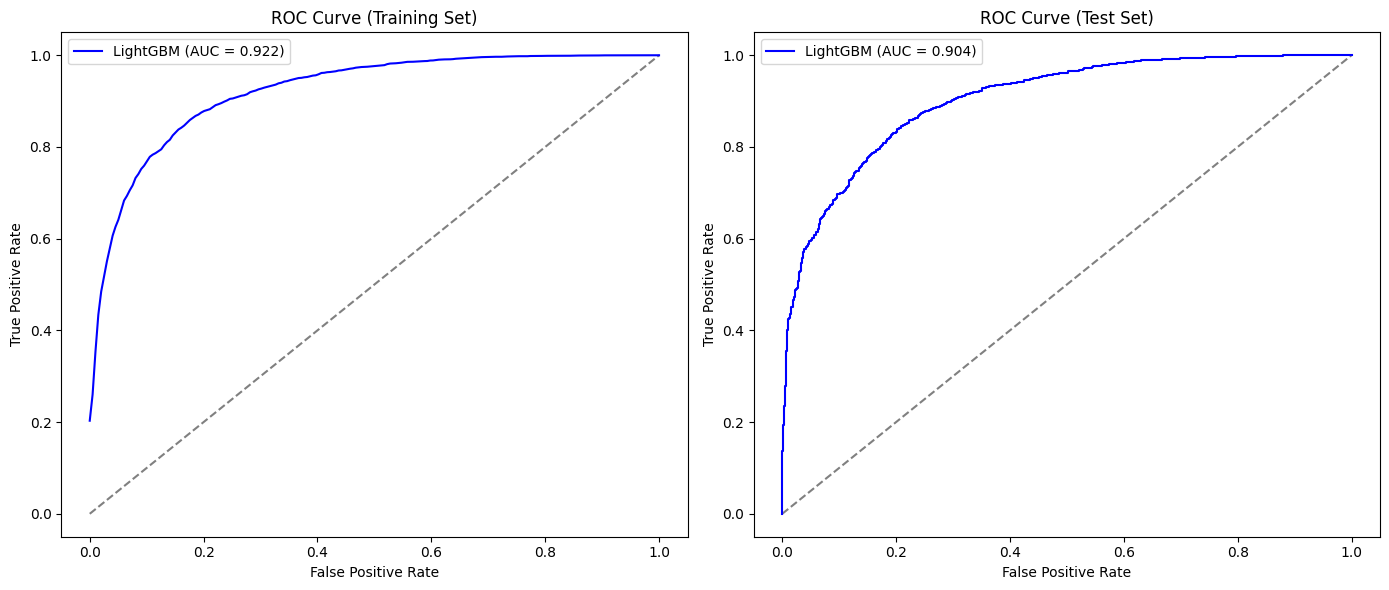

               Model  Accuracy  Sensitivity  Specificity  Precision  F1 Score  \
0  original_LightGBM  0.820345     0.849877     0.781385   0.836834  0.843305   

      AUROC  
0  0.903555  


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


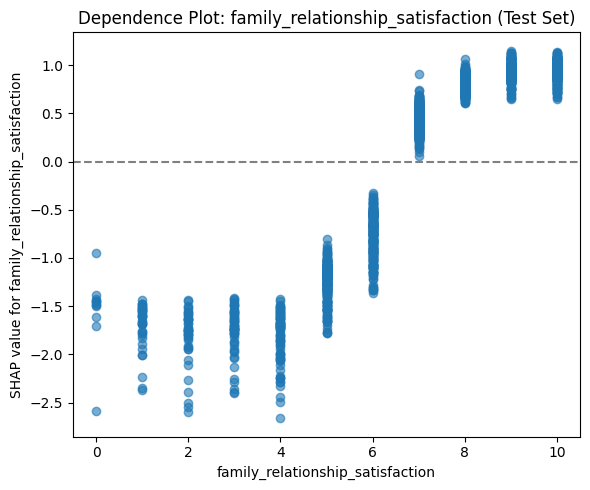

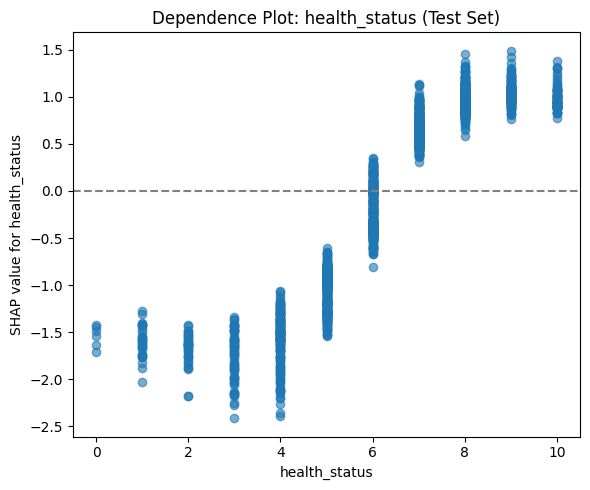

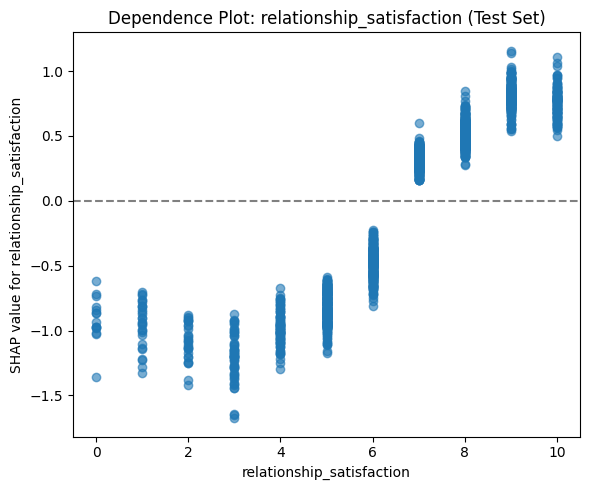

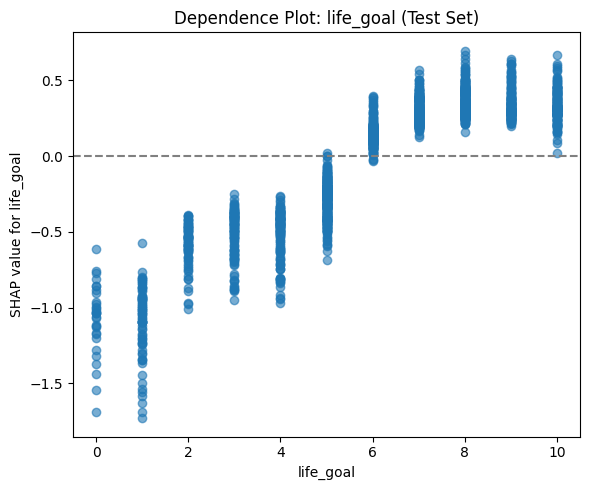

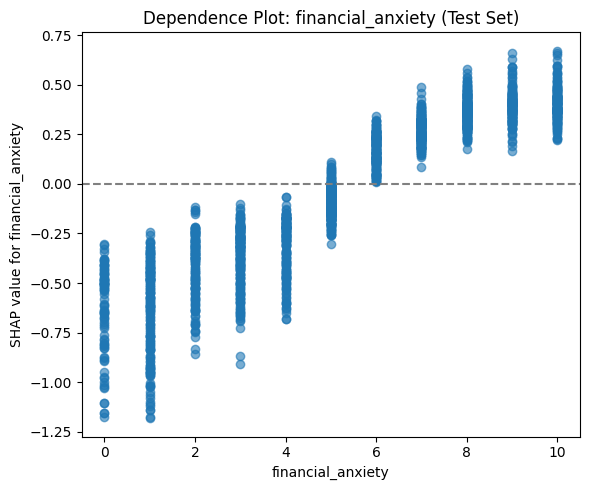

In [ ]:
# LightGBM ROC Curve, Performance Metrics, and SHAP Dependence Plots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import shap
import re

# Set random seed for reproducibility
RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)

# Define feature groups
ordinal_vars = [...]
nominal_vars = [...]
continuous_vars = [...]

# Prepare dataset
X_all = merged_data[ordinal_vars + nominal_vars + continuous_vars]
y = merged_data['SWB_category_y']

# Cast categorical variables
X_lgb = X_all.copy()
X_lgb[ordinal_vars] = X_lgb[ordinal_vars].astype('category')
X_lgb[nominal_vars] = X_lgb[nominal_vars].astype('category')

# Split and balance the training set
X_train_lgb, X_test_lgb, y_train_lgb, y_test = train_test_split(
    X_lgb, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
X_train_lgb, y_train_lgb = SMOTE(sampling_strategy=0.8, random_state=RANDOM_SEED).fit_resample(X_train_lgb, y_train_lgb)

# Model training
original_LightGBM = LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=RANDOM_SEED)
original_LightGBM.fit(X_train_lgb, y_train_lgb)

# Plot ROC curves (Train and Test)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
all_fpr = np.linspace(0, 1, 200)
plt.figure(figsize=(14, 6))

# Training ROC with 10-fold CV
plt.subplot(1, 2, 1)
plt.title("ROC Curve (Training Set)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
mean_tpr = np.zeros_like(all_fpr)
auc_scores = []

for train_idx, val_idx in kf.split(X_train_lgb, y_train_lgb):
    original_LightGBM.fit(X_train_lgb.iloc[train_idx], y_train_lgb.iloc[train_idx])
    y_pred_prob = original_LightGBM.predict_proba(X_train_lgb.iloc[val_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y_train_lgb.iloc[val_idx], y_pred_prob)
    auc_scores.append(auc(fpr, tpr))
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= kf.get_n_splits()
mean_auc = np.mean(auc_scores)
plt.plot(all_fpr, mean_tpr, label=f"LightGBM (AUC = {mean_auc:.3f})", color="blue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# Test ROC
plt.subplot(1, 2, 2)
plt.title("ROC Curve (Test Set)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
original_LightGBM.fit(X_train_lgb, y_train_lgb)
y_pred_prob = original_LightGBM.predict_proba(X_test_lgb)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {auc(fpr, tpr):.3f})", color="blue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Compute test set performance metrics
y_pred = original_LightGBM.predict(X_test_lgb)
y_pred_prob = original_LightGBM.predict_proba(X_test_lgb)[:, 1]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

metrics_df = pd.DataFrame({
    "Model": ["original_LightGBM"],
    "Accuracy": [accuracy_score(y_test, y_pred)],
    "Sensitivity": [recall_score(y_test, y_pred)],
    "Specificity": [tn / (tn + fp)],
    "Precision": [precision_score(y_test, y_pred)],
    "F1 Score": [f1_score(y_test, y_pred)],
    "AUROC": [roc_auc_score(y_test, y_pred_prob)]
})

print(metrics_df)
metrics_df.to_csv("lightgbm_metrics.csv", index=False)

# SHAP interpretation (Dependence Plots)
explainer = shap.TreeExplainer(original_LightGBM)
shap_values = explainer.shap_values(X_test_lgb)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Binary classification only

# Convert categories to numeric codes for plotting
X_test_numeric = X_test_lgb.copy()
for col in X_test_numeric.select_dtypes(include='category').columns:
    X_test_numeric[col] = X_test_numeric[col].cat.codes

# Aggregate SHAP values for dummy variables
def aggregate_shap(shap_vals, X, feature_names, method="signed"):
    shap_df = pd.DataFrame(shap_vals, columns=feature_names)
    X_df = pd.DataFrame(X, columns=feature_names)
    base_features = {}
    for col in feature_names:
        base = re.sub(r"_\d+$", "", col)
        base_features.setdefault(base, []).append(col)

    aggregated_shap = pd.DataFrame()
    aggregated_features = pd.DataFrame()
    for base, cols in base_features.items():
        if method == "abs":
            aggregated_shap[base] = shap_df[cols].abs().mean(axis=1)
        else:
            aggregated_shap[base] = shap_df[cols].mean(axis=1)
        aggregated_features[base] = X_df[cols].mean(axis=1)

    return aggregated_shap, aggregated_features

# Compute SHAP summary
shap_df_signed, X_df_signed = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="signed")
shap_df_abs, _ = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="abs")

# Plot dependence plots for top 5 features
top5_signed = shap_df_signed.abs().mean().sort_values(ascending=False).head(5).index.tolist()
for feature in top5_signed:
    plt.figure(figsize=(6, 5))
    plt.scatter(X_df_signed[feature], shap_df_signed[feature], alpha=0.6)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel(feature)
    plt.ylabel(f"SHAP value for {feature}")
    plt.title(f"Dependence Plot: {feature} (Test Set)")
    plt.tight_layout()
    plt.show()

#Debias 處理

##附加code

##Debias model:進行公平性調整（跑之前要先跑主要model)


⚖️ Reweighing Logistic（Sensitive: gender_2）...
✅ 調整完成並儲存至：adjusted_predictions/Logistic_gender_2_reweigh.csv

⚖️ Reweighing Logistic（Sensitive: income_x）...
✅ 調整完成並儲存至：adjusted_predictions/Logistic_income_x_reweigh.csv

⚖️ Reweighing RandomForest（Sensitive: gender_2）...
✅ 調整完成並儲存至：adjusted_predictions/RandomForest_gender_2_reweigh.csv

⚖️ Reweighing RandomForest（Sensitive: income_x）...
✅ 調整完成並儲存至：adjusted_predictions/RandomForest_income_x_reweigh.csv

⚖️ Reweighing GradientBoosting（Sensitive: gender_2）...
✅ 調整完成並儲存至：adjusted_predictions/GradientBoosting_gender_2_reweigh.csv

⚖️ Reweighing GradientBoosting（Sensitive: income_x）...
✅ 調整完成並儲存至：adjusted_predictions/GradientBoosting_income_x_reweigh.csv

⚖️ Reweighing XGBoost（Sensitive: gender_2）...
✅ 調整完成並儲存至：adjusted_predictions/XGBoost_gender_2_reweigh.csv

⚖️ Reweighing XGBoost（Sensitive: income_x）...
✅ 調整完成並儲存至：adjusted_predictions/XGBoost_income_x_reweigh.csv

⚖️ Reweighing LightGBM（Sensitive: gender_2）...
[LightGBM] [Info] Number of 

/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:66: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:67: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/preprocessing/reweighing.py:69: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_unfav = n_unfav*n_up / (n*n_up_unfav)


✅ 調整完成並儲存至：adjusted_predictions/LightGBM_gender_2_reweigh.csv

⚖️ Reweighing LightGBM（Sensitive: income_x）...
[LightGBM] [Info] Number of positive: 4310, number of negative: 5388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 9698, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472898 -> initscore=-0.108513
[LightGBM] [Info] Start training from score -0.108513
✅ 調整完成並儲存至：adjusted_predictions/LightGBM_income_x_reweigh.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ 已儲存並下載：fairness_performance_comparison_reweigh_final.csv


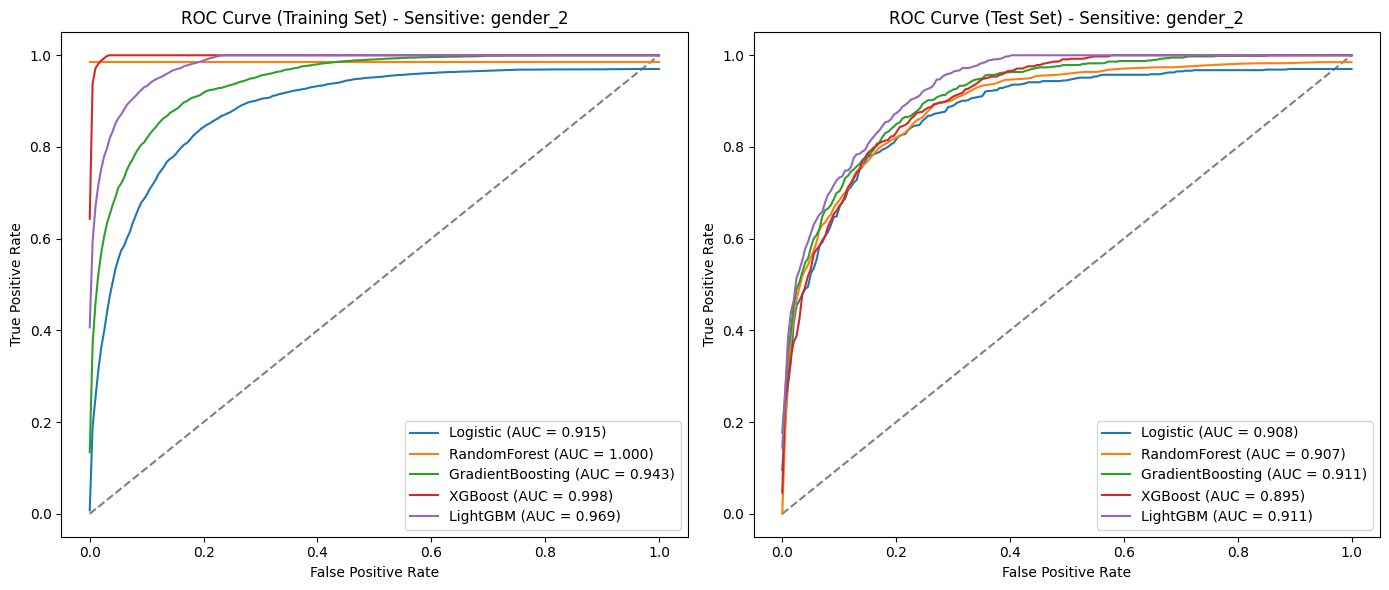

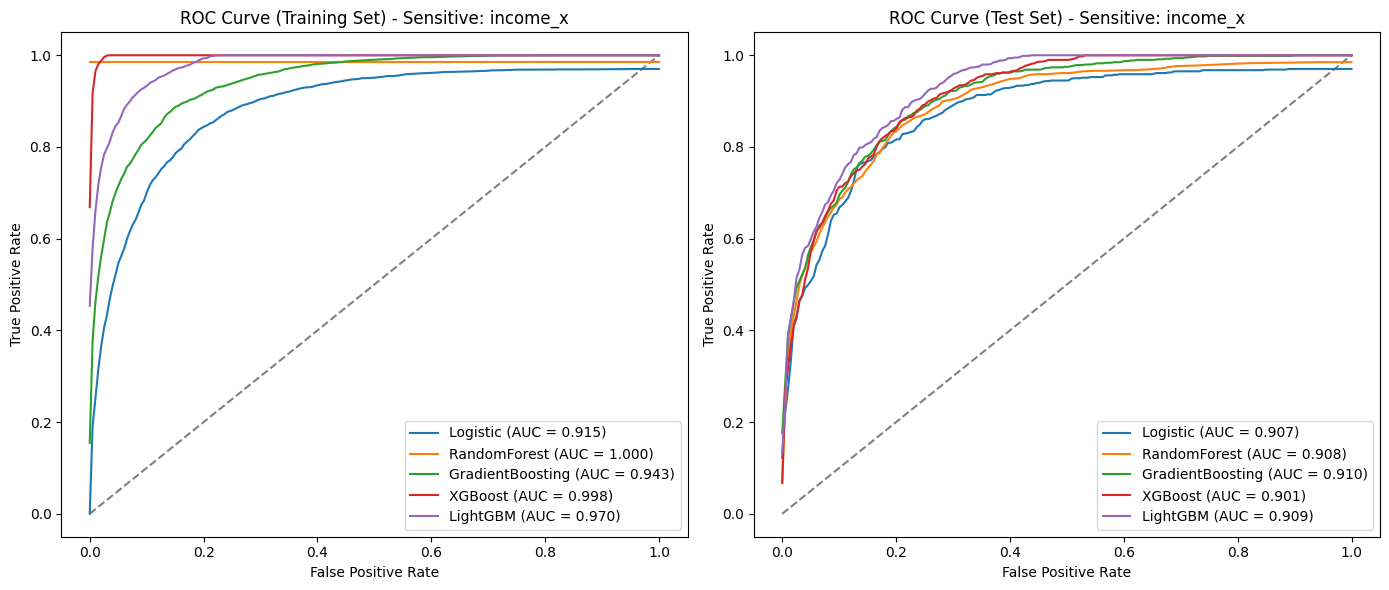

In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Configuration ===
sensitive_attrs = ["gender_2", "income_x"]
models_to_adjust = ["Logistic", "RandomForest", "GradientBoosting", "XGBoost", "LightGBM"]
adjusted_models = {}
os.makedirs("adjusted_predictions", exist_ok=True)

# === Reweighing for fairness adjustment ===
for model_name in models_to_adjust:
    for sensitive_attr in sensitive_attrs:
        print(f"\n⚖️ Reweighing {model_name}（Sensitive: {sensitive_attr}）...")

        if model_name == "LightGBM":
            X_train_input = X_train_lgb
            X_test_input = X_test_lgb
            y_train_input = y_train_lgb
            group_train = X_train_lgb[sensitive_attr].cat.codes if X_train_lgb[sensitive_attr].dtype.name == "category" else X_train_lgb[sensitive_attr]
        else:
            X_train_input = X_train_enc
            X_test_input = X_test_enc
            y_train_input = y_train_enc
            group_train = X_train_enc[sensitive_attr]

        df_train = pd.DataFrame({sensitive_attr: group_train, "true": y_train_input.values})

        aif_train = BinaryLabelDataset(
            df=df_train,
            label_names=["true"],
            protected_attribute_names=[sensitive_attr],
            favorable_label=1,
            unfavorable_label=0
        )

        reweigh = Reweighing(
            unprivileged_groups=[{sensitive_attr: 0}],
            privileged_groups=[{sensitive_attr: 1}]
        ).fit(aif_train)

        reweighted_train = reweigh.transform(aif_train)
        instance_weights = reweighted_train.instance_weights

        clf = LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=77) if model_name == "LightGBM" else models[model_name].__class__()
        clf.fit(X_train_input, y_train_input, sample_weight=instance_weights)

        y_pred = clf.predict(X_test_input)
        y_prob = clf.predict_proba(X_test_input)[:, 1]

        df_pred = pd.DataFrame({
            "true": y_test.values,
            "adjusted_pred": y_pred,
            "adjusted_score": y_prob,
            sensitive_attr: X_test_enc[sensitive_attr].values
        }).dropna()

        adjusted_models[f"debias_{model_name}_{sensitive_attr}"] = clf

        save_path = f"adjusted_predictions/{model_name}_{sensitive_attr}_reweigh.csv"
        df_pred.to_csv(save_path, index=False)
        print(f"✅ Saved adjusted results to: {save_path}")

# === Evaluate fairness and performance ===
fairness_df_before = pd.read_csv("fairness_metrics_before.csv")
performance_df = pd.read_csv("final_model_performance.csv")

fairness_rows = []

for model_name in models_to_adjust:
    for sensitive_attr in sensitive_attrs:
        path = f"adjusted_predictions/{model_name}_{sensitive_attr}_reweigh.csv"
        if not os.path.exists(path):
            continue

        df = pd.read_csv(path).dropna(subset=["true", "adjusted_pred", sensitive_attr])

        aif_true = BinaryLabelDataset(
            df=df,
            label_names=["true"],
            protected_attribute_names=[sensitive_attr],
            favorable_label=1,
            unfavorable_label=0
        )
        aif_pred = aif_true.copy()
        aif_pred.labels = df["adjusted_pred"].values.reshape(-1, 1)

        metric = ClassificationMetric(
            aif_true, aif_pred,
            unprivileged_groups=[{sensitive_attr: 0}],
            privileged_groups=[{sensitive_attr: 1}]
        )

        acc = accuracy_score(df["true"], df["adjusted_pred"])
        auc_val = roc_auc_score(df["true"], df["adjusted_score"])
        f1 = f1_score(df["true"], df["adjusted_pred"])
        tn, fp, fn, tp = confusion_matrix(df["true"], df["adjusted_pred"]).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        before_row = fairness_df_before[(fairness_df_before["Model"] == model_name) & (fairness_df_before["Sensitive Attr"] == sensitive_attr)]
        perf_row = performance_df[performance_df["Model"] == model_name]

        if not before_row.empty and not perf_row.empty:
            fairness_rows.append({
                "Model": f"debias_{model_name}",
                "Sensitive Attr": sensitive_attr,
                "Disparate Impact (Before)": before_row["Disparate Impact (Before)"].values[0],
                "Disparate Impact (After)": metric.disparate_impact(),
                "Δ Disparate Impact": metric.disparate_impact() - before_row["Disparate Impact (Before)"].values[0],
                "Equal Opportunity (Before)": before_row["Equal Opportunity (Before)"].values[0],
                "Equal Opportunity (After)": metric.equal_opportunity_difference(),
                "Δ Equal Opportunity": metric.equal_opportunity_difference() - before_row["Equal Opportunity (Before)"].values[0],
                "Equalized Odds (Before)": before_row["Equalized Odds (Before)"].values[0],
                "Equalized Odds (After)": metric.equalized_odds_difference(),
                "Δ Equalized Odds": metric.equalized_odds_difference() - before_row["Equalized Odds (Before)"].values[0],
                "Accuracy (Before)": perf_row["Accuracy"].values[0],
                "Accuracy (After)": acc,
                "Δ Accuracy": acc - perf_row["Accuracy"].values[0],
                "AUROC (Before)": perf_row["AUROC"].values[0],
                "AUROC (After)": auc_val,
                "F1 Score (After)": f1,
                "Recall (Sensitivity)": sensitivity,
                "Specificity": specificity
            })

result_df = pd.DataFrame(fairness_rows)
result_df.to_csv("fairness_performance_comparison_reweigh_final.csv", index=False)
print("\n✅ Fairness comparison saved: fairness_performance_comparison_reweigh_final.csv")

# === ROC Curve Plotting ===
offset = 0.015
all_fpr = np.linspace(0, 1, 200)
colors = plt.get_cmap("tab10")

for sensitive_attr in sensitive_attrs:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.title(f"ROC Curve (Training Set) - Sensitive: {sensitive_attr}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    for i, model_name in enumerate(models_to_adjust):
        key = f"debias_{model_name}_{sensitive_attr}"
        model = adjusted_models[key]

        X_train_input = X_train_lgb if model_name == "LightGBM" else X_train_enc
        y_train_input = y_train_lgb if model_name == "LightGBM" else y_train_enc

        y_train_prob = model.predict_proba(X_train_input)[:, 1]
        fpr, tpr, _ = roc_curve(y_train_input, y_train_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(all_fpr, np.clip(np.interp(all_fpr, fpr, tpr) + (i - 2) * offset, 0, 1),
                 label=f"{model_name} (AUC = {roc_auc:.3f})", color=colors(i))

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"ROC Curve (Test Set) - Sensitive: {sensitive_attr}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    for i, model_name in enumerate(models_to_adjust):
        path = f"adjusted_predictions/{model_name}_{sensitive_attr}_reweigh.csv"
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        fpr, tpr, _ = roc_curve(df["true"], df["adjusted_score"])
        roc_auc = auc(fpr, tpr)
        plt.plot(all_fpr, np.clip(np.interp(all_fpr, fpr, tpr) + (i - 2) * offset, 0, 1),
                 label=f"{model_name} (AUC = {roc_auc:.3f})", color=colors(i))

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()


####SHAP


📊 SHAP 解釋：LightGBM 調整後模型（敏感變項：gender_2）


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
<ipython-input-22-b20ed00ff3e8>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)


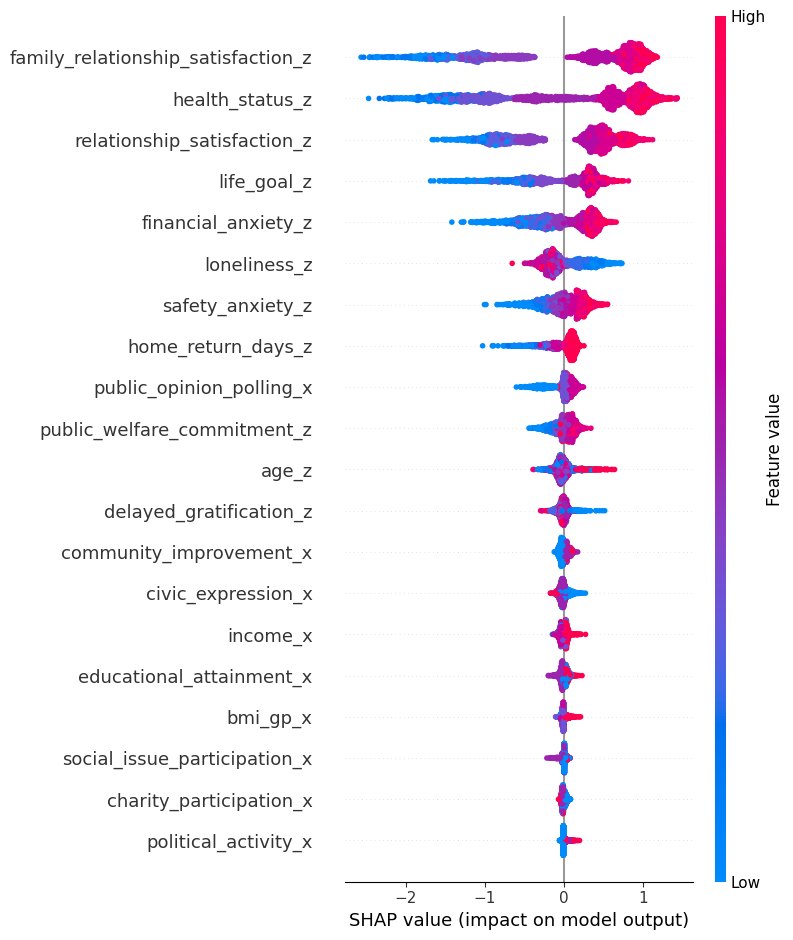

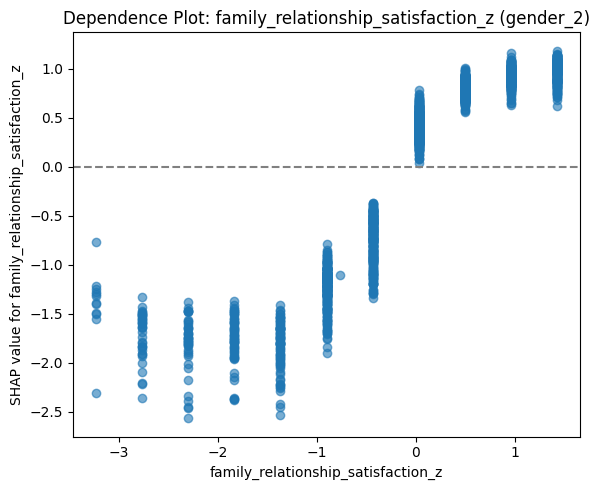

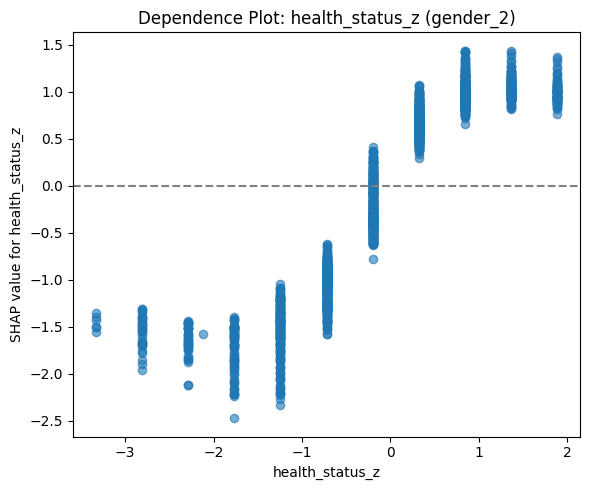

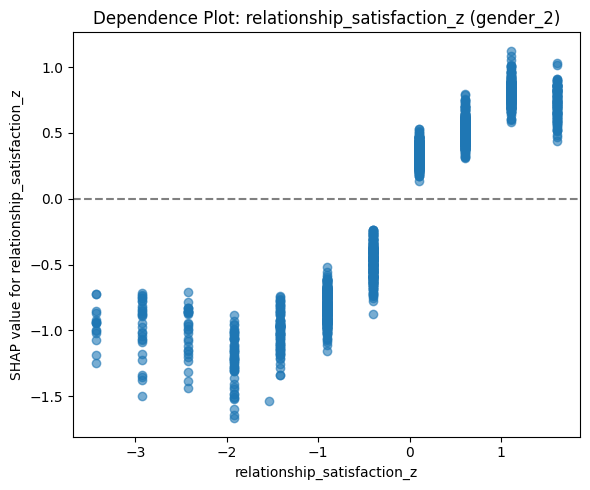

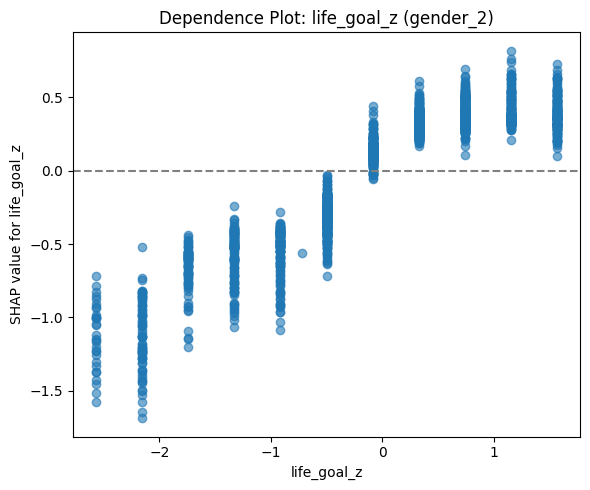

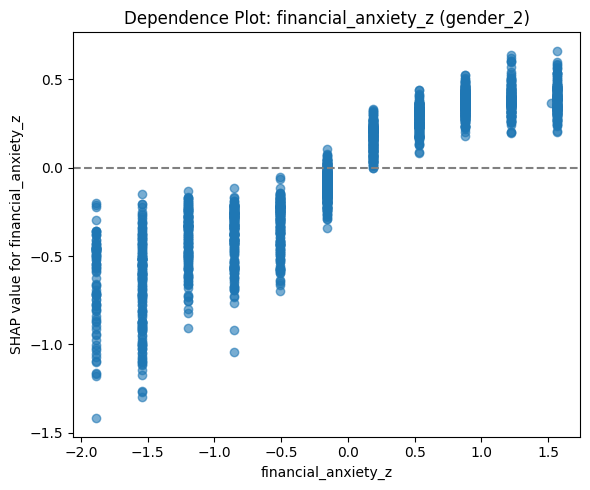

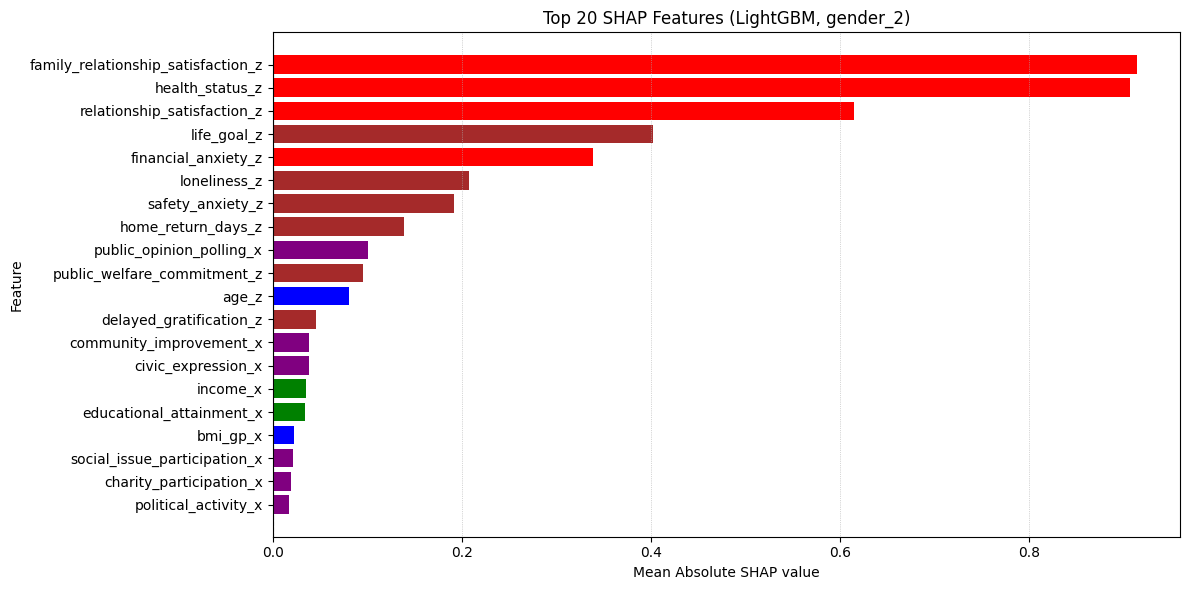

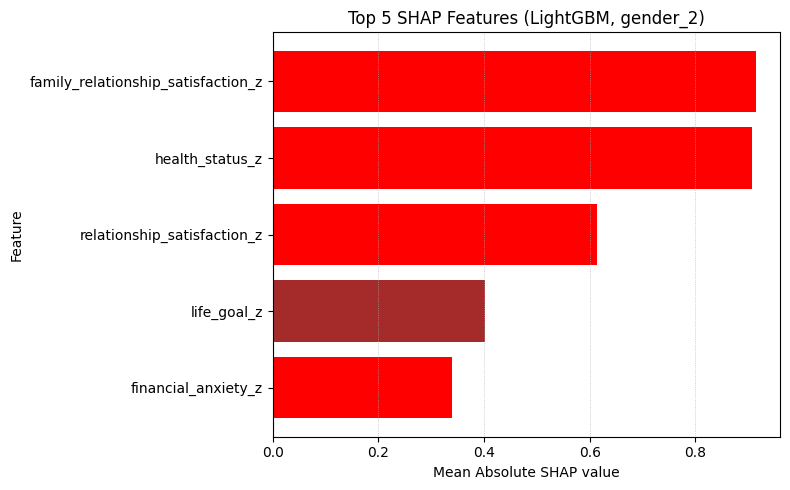


📊 SHAP 解釋：LightGBM 調整後模型（敏感變項：income_x）


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
<ipython-input-22-b20ed00ff3e8>:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)


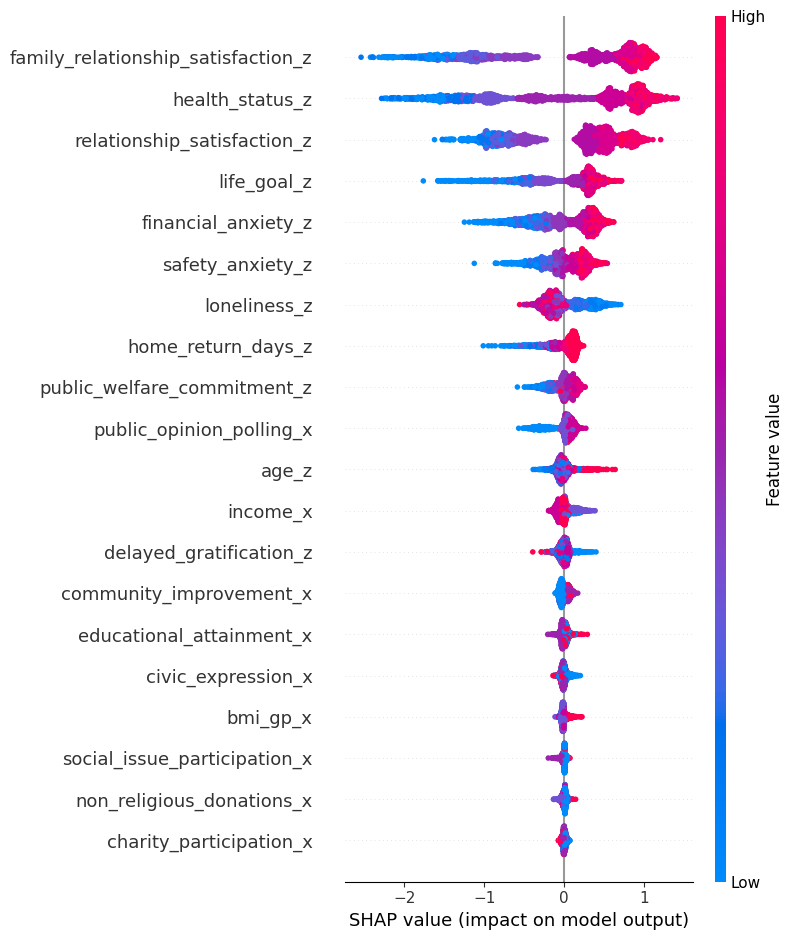

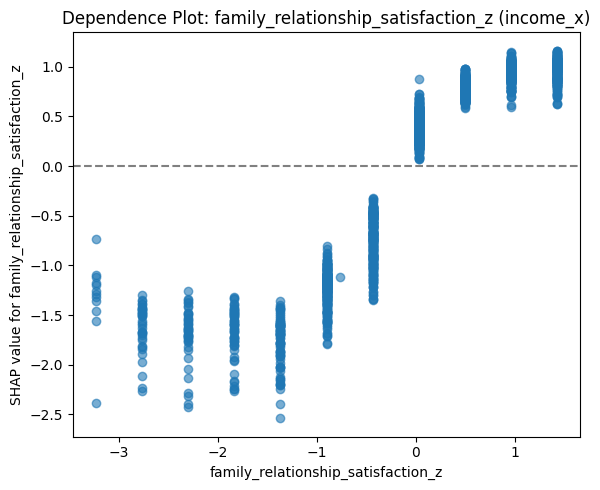

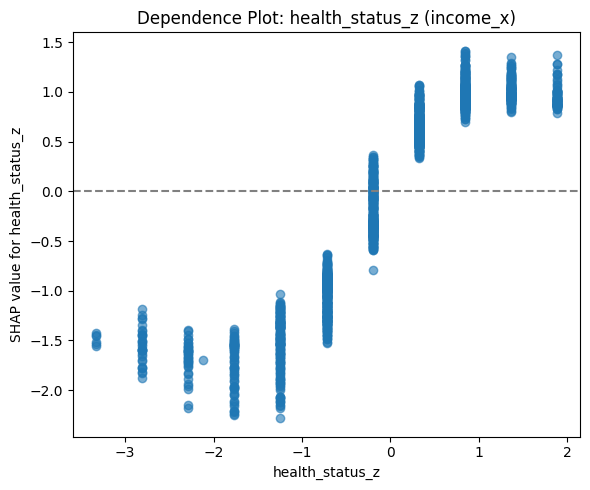

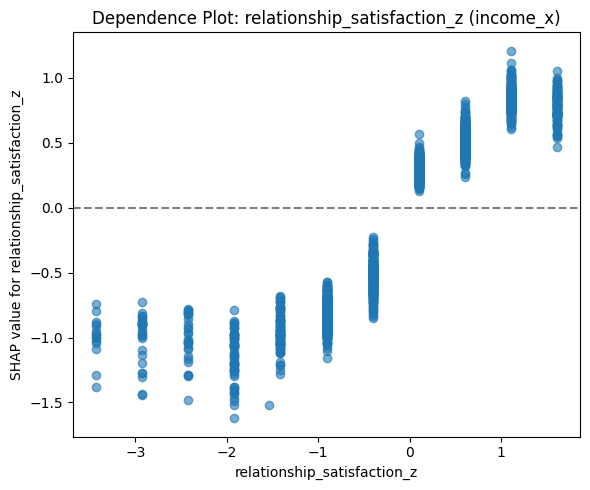

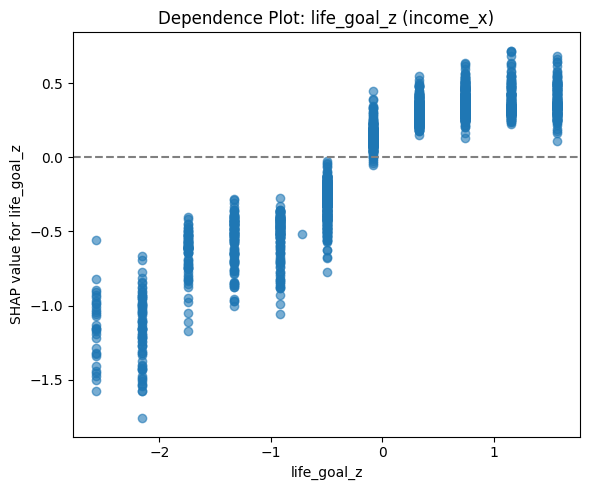

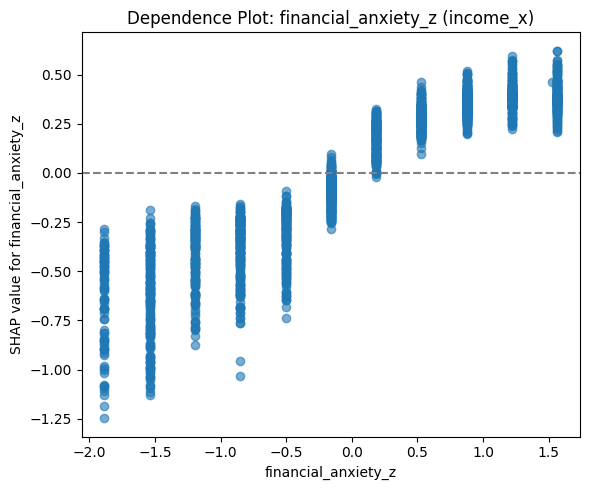

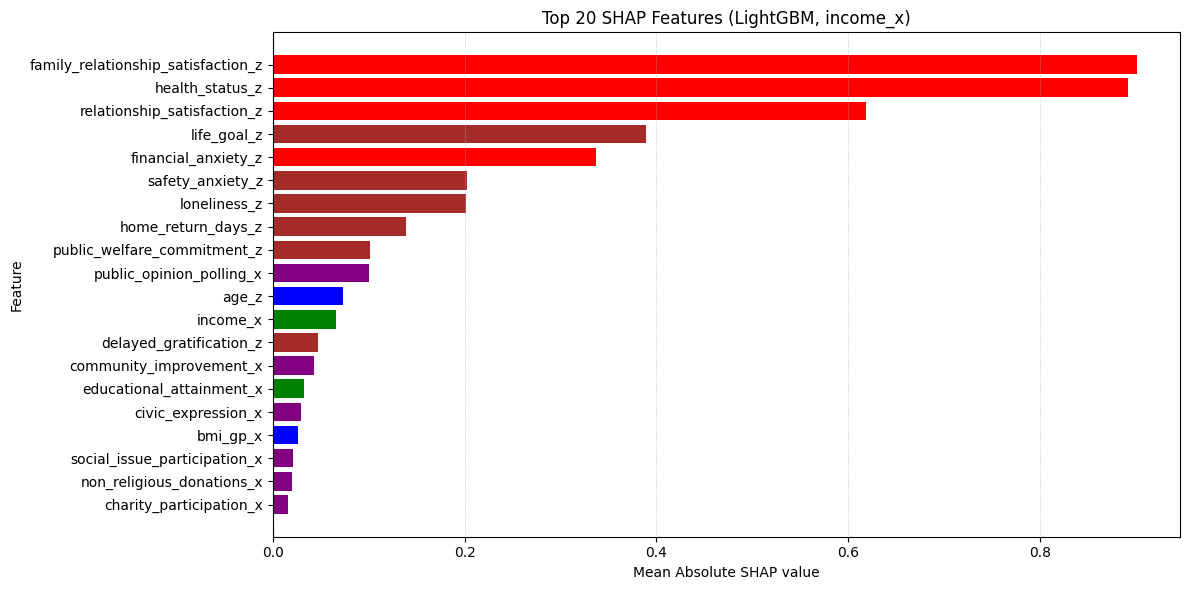

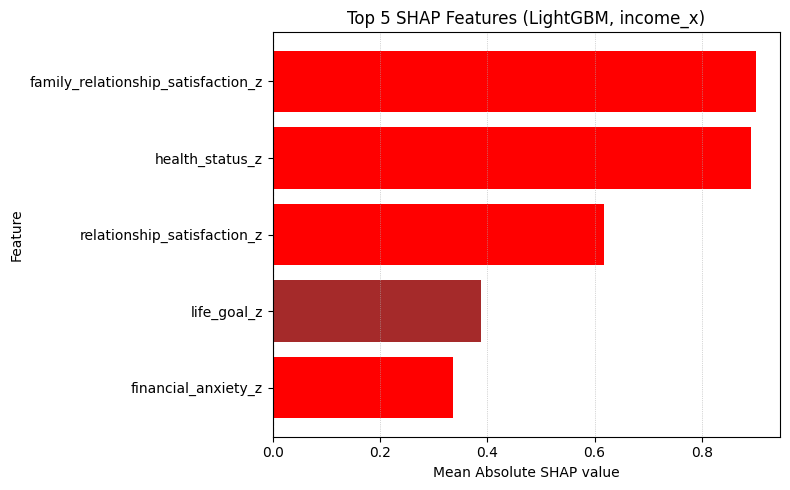

In [ ]:
import shap
import matplotlib.pyplot as plt

# Loop through each sensitive attribute for debiased LightGBM models
for sensitive_attr in ["gender_2", "income_x"]:
    key = f"debias_LightGBM_{sensitive_attr}"
    model = adjusted_models[key]

    print(f"\n📊 SHAP Interpretation: Debiased LightGBM Model (Sensitive Attribute: {sensitive_attr})")

    # Initialize SHAP TreeExplainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_lgb)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Binary classification

    # Convert categorical variables to numeric codes for plotting
    X_test_numeric = X_test_lgb.copy()
    for col in X_test_numeric.select_dtypes(include='category').columns:
        X_test_numeric[col] = X_test_numeric[col].cat.codes

    # Aggregate SHAP values (signed and absolute)
    shap_df_signed, X_df_signed = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="signed")
    shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)

    # Generate dependence plots for top 5 features (by mean absolute SHAP)
    top5_signed = shap_df_signed.abs().mean().sort_values(ascending=False).head(5).index.tolist()
    for feature in top5_signed:
        plt.figure(figsize=(6, 5))
        plt.scatter(X_df_signed[feature], shap_df_signed[feature], alpha=0.6)
        plt.axhline(0, color='gray', linestyle='--')
        plt.xlabel(feature)
        plt.ylabel(f"SHAP value for {feature}")
        plt.title(f"Dependence Plot: {feature} ({sensitive_attr})")
        plt.tight_layout()
        plt.show()

    # Feature coloring function based on predefined categories
    def get_feature_color(f):
        for cat, vars in categories.items():
            if f in vars:
                return category_colors[cat]
        return 'gray'

    # Generate Top 20 SHAP bar chart
    shap_df_abs, _ = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="abs")
    mean_abs_vals = shap_df_abs.mean().sort_values(ascending=False).head(20)
    colors = [get_feature_color(f) for f in mean_abs_vals.index]

    plt.figure(figsize=(12, 6))
    plt.barh(mean_abs_vals.index[::-1], mean_abs_vals.values[::-1], color=colors[::-1])
    plt.xlabel("Mean Absolute SHAP value")
    plt.ylabel("Feature")
    plt.title(f"Top 20 SHAP Features (LightGBM, {sensitive_attr})")
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.grid(axis='x', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Generate Top 5 SHAP bar chart
    mean_abs_vals_top5 = mean_abs_vals.head(5)
    plt.figure(figsize=(8, 5))
    plt.barh(mean_abs_vals_top5.index[::-1], mean_abs_vals_top5.values[::-1],
             color=[get_feature_color(f) for f in mean_abs_vals_top5.index[::-1]])
    plt.xlabel("Mean Absolute SHAP value")
    plt.ylabel("Feature")
    plt.title(f"Top 5 SHAP Features (LightGBM, {sensitive_attr})")
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.grid(axis='x', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Report unclassified features (not assigned to any predefined category)
    uncategorized_features = [f for f in mean_abs_vals.index if get_feature_color(f) == 'gray']
    if uncategorized_features:
        print(f"⚠️ Unclassified features in LightGBM + {sensitive_attr}:")
        for f in uncategorized_features:
            print("-", f)


###視覺化公平性調整效果

##效能與公平性 trade off plot（未改）

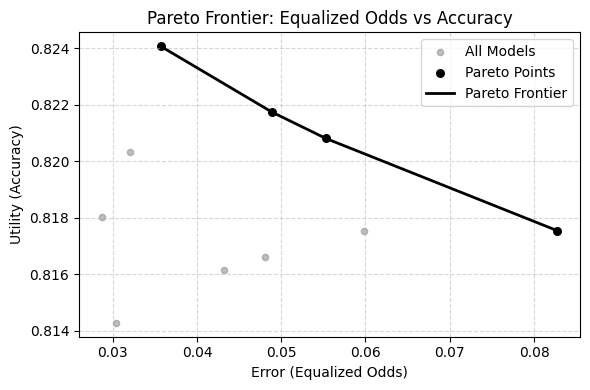

In [ ]:
# ========== 1. Import libraries ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ========== 2. Load fairness evaluation results ==========
fairness_results = pd.read_csv("fairness_performance_comparison_reweigh_final.csv")

# ========== 3. Define Pareto frontier and smoothing functions ==========
# Identify Pareto-efficient points
def get_pareto_frontier(X, Y, maximize_X=False, maximize_Y=True):
    sorted_indices = np.argsort(X) if maximize_X else np.argsort(X)[::-1]
    X_sorted = np.array(X)[sorted_indices]
    Y_sorted = np.array(Y)[sorted_indices]

    pareto_X, pareto_Y = [], []
    best_Y = -np.inf if maximize_Y else np.inf

    for x, y in zip(X_sorted, Y_sorted):
        if (maximize_Y and y > best_Y) or (not maximize_Y and y < best_Y):
            pareto_X.append(x)
            pareto_Y.append(y)
            best_Y = y

    return np.array(pareto_X), np.array(pareto_Y)

# Smooth Pareto curve for better visualization
def smooth_pareto_curve(X, Y, num_points=100):
    X = np.array(X)
    Y = np.array(Y)

    if len(np.unique(X)) < len(X):
        unique_X, unique_indices = np.unique(X, return_index=True)
        X = unique_X
        Y = Y[unique_indices]
        X += np.random.normal(0, 1e-6, X.shape)  # avoid duplicates

    if len(X) > 5:
        f_interp = interp1d(X, Y, kind="linear", fill_value="extrapolate")
        X_smooth = np.linspace(min(X), max(X), num_points)
        Y_smooth = f_interp(X_smooth)
    else:
        X_smooth, Y_smooth = X, Y

    return X_smooth, Y_smooth

# ========== 4. Compute Pareto Frontier (Equalized Odds vs Accuracy) ==========
pareto_eq_odds_X, pareto_eq_odds_Y = get_pareto_frontier(
    fairness_results["Equalized Odds (After)"],
    fairness_results["Accuracy (After)"],
    maximize_X=False, maximize_Y=True
)

smooth_eq_odds_X, smooth_eq_odds_Y = smooth_pareto_curve(pareto_eq_odds_X, pareto_eq_odds_Y)

# ========== 5. Plot ==========
fig, ax = plt.subplots(figsize=(6, 4))

# Plot all models
ax.scatter(fairness_results["Equalized Odds (After)"], fairness_results["Accuracy (After)"],
           color="gray", alpha=0.5, s=20, label="All Models")

# Highlight Pareto-efficient points
ax.scatter(pareto_eq_odds_X, pareto_eq_odds_Y, color="black", s=30, label="Pareto Points")

# Plot smoothed Pareto frontier
ax.plot(smooth_eq_odds_X, smooth_eq_odds_Y, "k-", linewidth=2, label="Pareto Frontier")

ax.set_title("Pareto Frontier: Equalized Odds vs Accuracy")
ax.set_xlabel("Error (Equalized Odds)")
ax.set_ylabel("Utility (Accuracy)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


##SWB as a contineous variable

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 8569, number of used features: 40
[LightGBM] [Info] Start training from score 6.359669


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 所有模型表現結果（含 LightGBM）已儲存並下載 model_comparison_results.csv


<ipython-input-38-c7bd7e6f345d>:119: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)


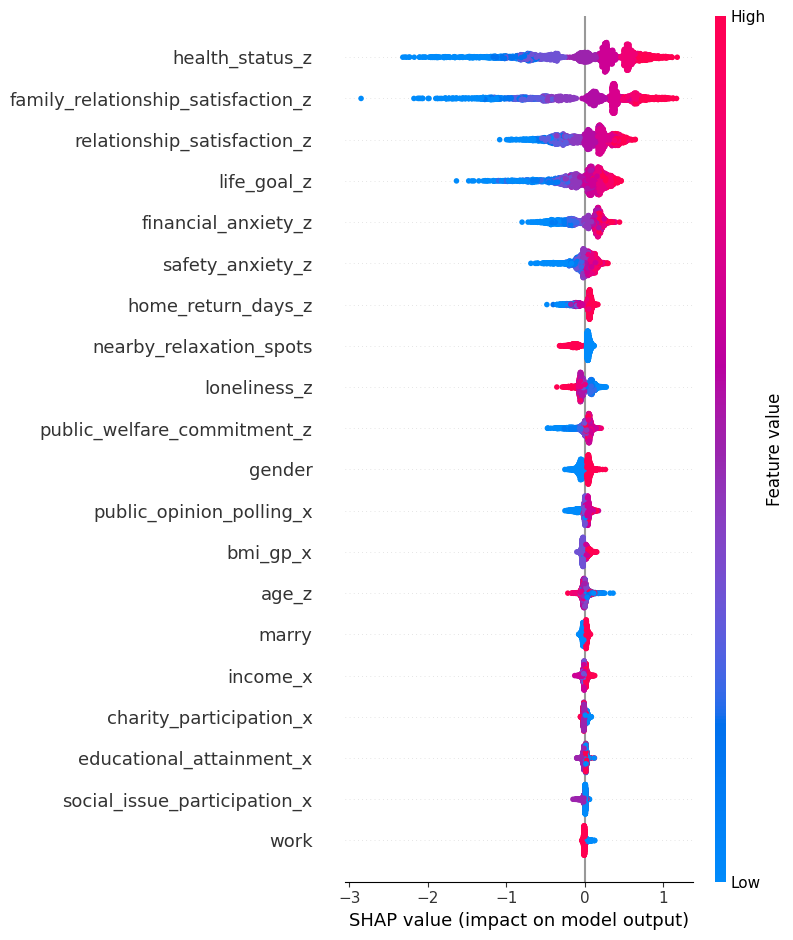

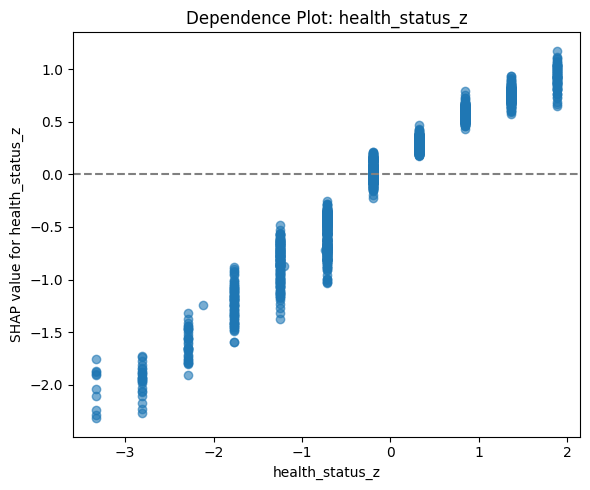

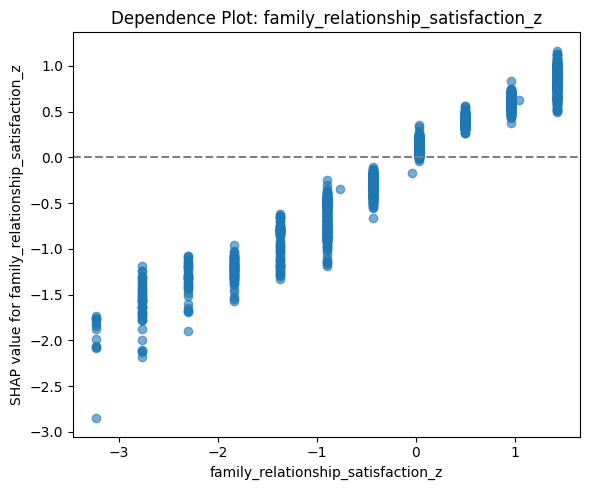

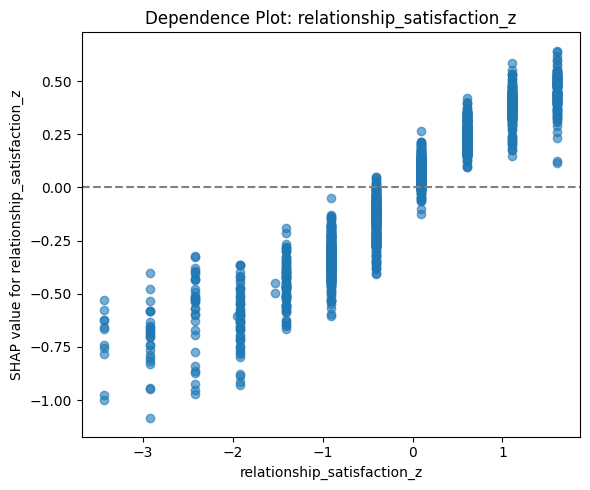

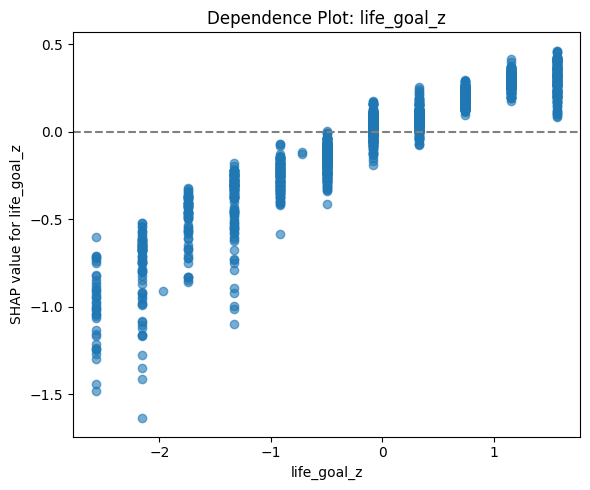

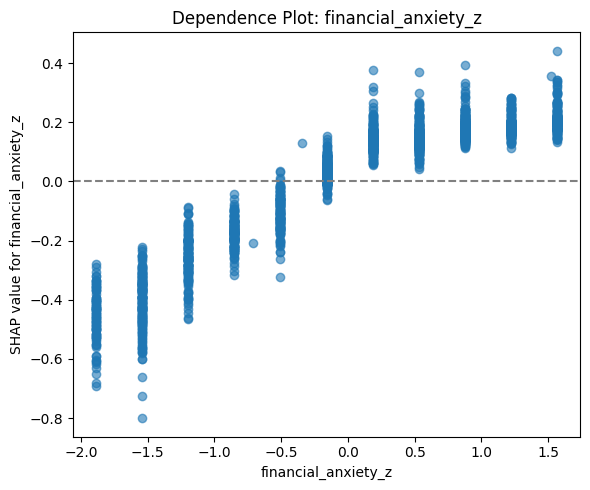

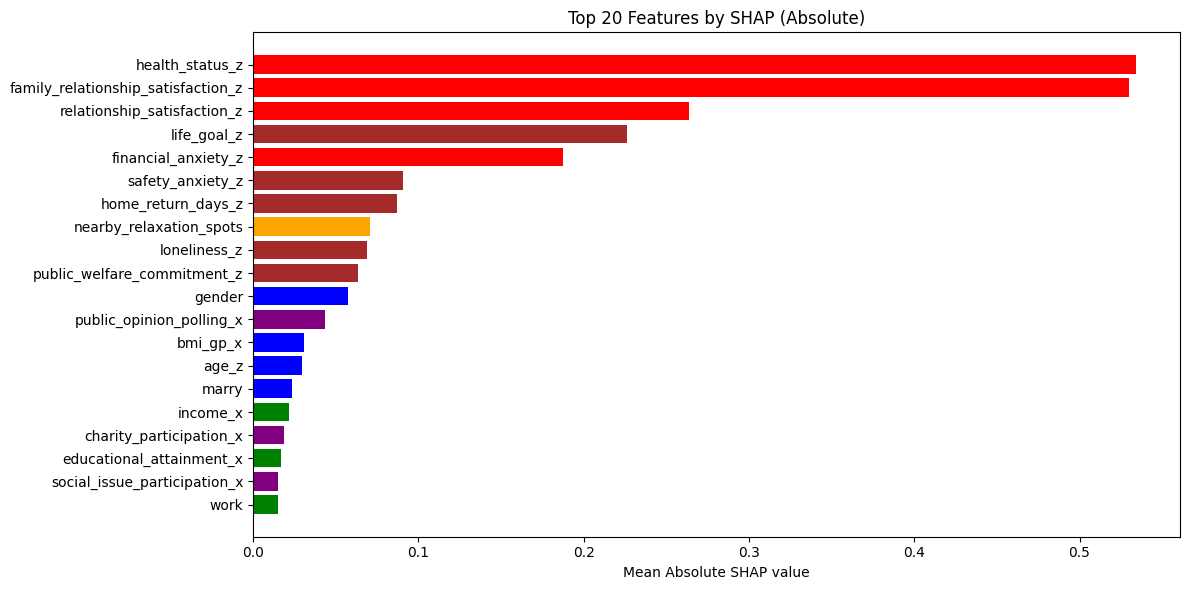

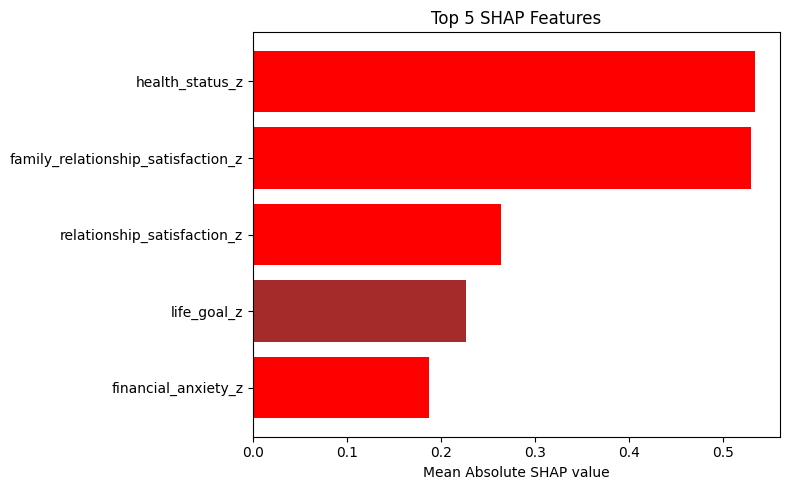

In [ ]:
# ========== 1. Import packages and set random seed ==========
# Import necessary libraries for data processing, modeling, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from google.colab import files

# Set a global random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ========== 2. Variable definitions ==========
# Define feature lists grouped by measurement level (ordinal, nominal, continuous)
ordinal_vars = [
    'charity_participation_x', 'community_improvement_x', 'volunteer_work_x', 'community_meetings_x',
    'social_issue_participation_x', 'political_activity_x', 'religious_donations_x',
    'non_religious_donations_x', 'helping_others_x', 'public_opinion_polling_x',
    'civic_expression_x', 'bmi_gp_x', 'income_x', 'educational_attainment_x'
]

nominal_vars = [
    'gender_2', 'region_2', 'region_3', 'region_4',
    'religion_2', 'religion_3', 'religion_4',
    'nearby_shops_2', 'nearby_transit_2', 'nearby_cultural_sites_2',
    'nearby_relaxation_spots_2', 'traffic_safety_2', 'crime_safety_2',
    'work_1', 'marry_1'
]

continuous_vars = [
    'age_z', 'home_return_days_z', 'health_status_z',
    'relationship_satisfaction_z',
    'family_relationship_satisfaction_z', 'loneliness_z', 'life_goal_z',
    'public_welfare_commitment_z', 'delayed_gratification_z',
    'financial_anxiety_z', 'safety_anxiety_z'
]

# ========== 3. Extract raw features and outcome ==========
# Select input features and the target variable from merged dataset
X_raw = merged_data[ordinal_vars + nominal_vars + continuous_vars].copy()
y = merged_data["swb"]

# ========== 4. Preprocessing for linear models ==========
# Transform ordinal variables using ordinal encoding
X_ordinal = pd.DataFrame(OrdinalEncoder().fit_transform(X_raw[ordinal_vars]), columns=ordinal_vars)

# Convert nominal variables into dummy variables (one-hot encoding)
X_nominal = pd.get_dummies(X_raw[nominal_vars], drop_first=True)

# Retain continuous variables
X_continuous = X_raw[continuous_vars]

# Combine all encoded and continuous features
X_linear = pd.concat([X_ordinal, X_nominal, X_continuous], axis=1)

# Impute missing values using median strategy
X_linear = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_linear), columns=X_linear.columns)

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_linear, y, test_size=0.2, random_state=RANDOM_SEED)

# ========== 5. Fit baseline linear models ==========
# Train Linear Regression, Lasso, and Ridge models and evaluate performance
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0)
}
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "R²": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

# ========== 6. Train LightGBM model ==========
# Prepare and train a LightGBM model using categorical handling
X_raw_lgb = merged_data[ordinal_vars + nominal_vars + continuous_vars].copy()
X_raw_lgb[ordinal_vars + nominal_vars] = X_raw_lgb[ordinal_vars + nominal_vars].astype("category")
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_raw_lgb, y, test_size=0.2, random_state=RANDOM_SEED)
lgb_model = LGBMRegressor(n_estimators=150, learning_rate=0.05, random_state=RANDOM_SEED)
lgb_model.fit(X_train_lgb, y_train_lgb)

# Predict and store performance metrics
y_pred_lgb = lgb_model.predict(X_test_lgb)
results.append({
    "Model": "LightGBM",
    "R²": r2_score(y_test_lgb, y_pred_lgb),
    "MAE": mean_absolute_error(y_test_lgb, y_pred_lgb),
    "RMSE": np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))
})

# ========== 7. Save and download model comparison results ==========
# Output model performance to CSV and trigger download
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results.csv", index=False)
files.download("model_comparison_results.csv")
print("✅ 所有模型表現結果（含 LightGBM）已儲存並下載 model_comparison_results.csv")

# ========== 8. SHAP analysis for LightGBM ==========
# Apply SHAP interpretation for LightGBM model
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_lgb)

# Convert categorical features to numeric codes for SHAP plotting
X_test_numeric = X_test_lgb.copy()
for col in X_test_numeric.select_dtypes(include='category').columns:
    X_test_numeric[col] = X_test_numeric[col].cat.codes

# Function: aggregate SHAP values across one-hot encoded or grouped features
def aggregate_shap(shap_vals, X, feature_names, method="signed"):
    shap_df = pd.DataFrame(shap_vals, columns=feature_names)
    X_df = pd.DataFrame(X, columns=feature_names)
    base_features = {}
    for col in feature_names:
        base = re.sub(r"_\d+$", "", col)
        base_features.setdefault(base, []).append(col)

    aggregated_shap = pd.DataFrame()
    aggregated_features = pd.DataFrame()
    for base, cols in base_features.items():
        if method == "abs":
            aggregated_shap[base] = shap_df[cols].abs().mean(axis=1)
        else:
            aggregated_shap[base] = shap_df[cols].mean(axis=1)
        aggregated_features[base] = X_df[cols].mean(axis=1)
    return aggregated_shap, aggregated_features

# Run signed SHAP aggregation and plot global summary
shap_df_signed, X_df_signed = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="signed")
shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)

# Plot top 5 SHAP dependence plots
top5 = shap_df_signed.abs().mean().sort_values(ascending=False).head(5).index.tolist()
for f in top5:
    plt.figure(figsize=(6, 5))
    plt.scatter(X_df_signed[f], shap_df_signed[f], alpha=0.6)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel(f)
    plt.ylabel(f"SHAP value for {f}")
    plt.title(f"Dependence Plot: {f}")
    plt.tight_layout()
    plt.show()

# ========== 9. Visualize SHAP values (Top 20 and Top 5) ==========
# Define feature category colors for plotting
category_colors = {
    'Demographic Variables': 'blue',
    'Socioeconomic Variables': 'green',
    'Neighborhood Environment Variables': 'orange',
    'Social Participation Variables': 'purple',
    'Health and Satisfaction Variables': 'red',
    'Psychological and Behavioral Variables': 'brown'
}

# Define the mapping of features to categories
categories = {
    'Demographic Variables': ['gender', 'region', 'religion_2', 'religion_3', 'religion_4', 'age_z', 'marry', 'bmi_gp_x'],
    'Socioeconomic Variables': ['work', 'work_1', 'income_x', 'educational_attainment_x'],
    'Neighborhood Environment Variables': ['nearby_shops_2', 'nearby_relaxation_spots', 'traffic_safety_2',
                                           'crime_safety', 'nearby_cultural_sites', 'nearby_cultural_sites_2'],
    'Social Participation Variables': ['charity_participation_x', 'community_improvement_x', 'volunteer_work_x',
                                       'community_meetings_x', 'social_issue_participation_x', 'political_activity_x',
                                       'religious_donations_x', 'non_religious_donations_x', 'helping_others_x',
                                       'public_opinion_polling_x', 'civic_expression_x'],
    'Health and Satisfaction Variables': ['health_status_z', 'relationship_satisfaction_z', 'financial_anxiety_z',
                                          'family_relationship_satisfaction_z'],
    'Psychological and Behavioral Variables': ['public_welfare_commitment_z', 'delayed_gratification_z',
                                               'safety_anxiety_z', 'life_goal_z', 'home_return_days_z', 'loneliness_z']
}

# Helper function to get color based on feature category
def get_feature_color(f):
    for cat, vars in categories.items():
        if f in vars:
            return category_colors[cat]
    return 'gray'

# Compute mean absolute SHAP values
shap_df_abs, _ = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="abs")
mean_abs_vals = shap_df_abs.mean().sort_values(ascending=False).head(20)
colors = [get_feature_color(f) for f in mean_abs_vals.index]

# Bar chart of Top 20 SHAP features
plt.figure(figsize=(12, 6))
plt.barh(mean_abs_vals.index[::-1], mean_abs_vals.values[::-1], color=colors[::-1])
plt.xlabel("Mean Absolute SHAP value")
plt.title("Top 20 Features by SHAP (Absolute)")
plt.tight_layout()
plt.show()

# Bar chart of Top 5 SHAP features
top5_vals = mean_abs_vals.head(5)
plt.figure(figsize=(8, 5))
plt.barh(top5_vals.index[::-1], top5_vals.values[::-1],
         color=[get_feature_color(f) for f in top5_vals.index[::-1]])
plt.title("Top 5 SHAP Features")
plt.xlabel("Mean Absolute SHAP value")
plt.tight_layout()
plt.show()

# Print out uncategorized features (if any)
uncategorized = [f for f in mean_abs_vals.index if get_feature_color(f) == 'gray']
if uncategorized:
    print("⚠️ Uncategorized features (displayed in gray):")
    for f in uncategorized:
        print(f"- {f}")


##SWB 7 point cutoff

In [ ]:
# ========== Import Libraries ==========
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from google.colab import files

# ========== Upload File ==========
# Prompt user to upload a CSV file
print("Please upload your file:")
uploaded = files.upload()

# Retrieve uploaded file name
file_name = list(uploaded.keys())[0]
print(f"Reading the file: {file_name}")

# Attempt to read the file using ISO-8859-1 encoding
happiness_data = pd.read_csv(file_name, encoding='ISO-8859-1')

# Preview the first few rows
print("Here is a preview of your data:")
print(happiness_data.head())


Please upload your file:


Saving ml_(swb七分為界)1130310 1929csv.csv to ml_(swb七分為界)1130310 1929csv (4).csv
Reading the file: ml_(swb七分為界)1130310 1929csv (4).csv
Here is a preview of your data:
   id_me       id  id_new  group      sendtime  smstime1  smstime2  gender  \
0      1     10.0     NaN      1  2.020000e+13       NaN       NaN       2   
1      2    100.0     NaN      1  2.020000e+13       NaN       NaN       2   
2      3  10000.0     NaN      1  2.020000e+13       NaN       NaN       1   
3      4  10003.0     NaN      1  2.020000e+13       NaN       NaN       2   
4      5  10006.0     NaN      1  2.020000e+13       NaN       NaN       1   

   v2  v53city  ...  loneliness_z  life_purpose_z  life_goal_z  \
0  73        2  ...     -1.482577       -0.248517    -1.328270   
1  80        4  ...      0.681742       -0.248517    -1.328270   
2  85       14  ...      0.681742        0.243869     0.325505   
3  75       15  ...      1.403181        0.243869    -0.501383   
4  55       15  ...      0.321022    

In [ ]:
# ========== Define Ordered and Nominal Variables ==========

# Define ordinal (ordered) categorical variables to retain original integer encoding
ordinal_vars = [
    'charity_participation', 'community_improvement', 'volunteer_work', 'community_meetings',
    'social_issue_participation', 'political_activity', 'religious_donations',
    'non_religious_donations', 'helping_others', 'public_opinion_polling',
    'civic_expression', 'bmi_gp', 'income', 'educational_attainment'
]

# Define nominal (unordered) categorical variables to be one-hot encoded
nominal_vars = [
    'gender', 'region', 'religion', 'nearby_cultural_sites',
    'nearby_relaxation_spots', 'traffic_safety', 'crime_safety',
    'work', 'marry', 'nearby_shops', 'nearby_transit'
]

# ========== Step 1: Ordinal Encoding ==========

# Assume all ordinal variables are already coded as integers and in the correct order
df[ordinal_vars] = df[ordinal_vars].astype('int')

# ========== Step 2: One-Hot Encoding for Nominal Variables ==========

# Convert nominal variables to categorical type to prepare for one-hot encoding
df[nominal_vars] = df[nominal_vars].astype("category")

# Perform one-hot encoding (drop_first=True avoids multicollinearity)
df_nominal = pd.get_dummies(df[nominal_vars], drop_first=True)

# ========== Step 3: Combine Encoded Features ==========

# Concatenate ordinal and nominal-encoded features into one dataset
used_df = pd.concat([df[ordinal_vars], df_nominal], axis=1)

# ========== Step 4: Add ID and Target Variable ==========

# Append ID column and the binary target variable
used_df['id_me'] = df['id_me']
used_df['SWB_category'] = df['SWB_category']

# ========== Step 5: Preview and Verify ==========

# Show the first few rows of the processed dataset
print(used_df.head())

# ========== Step 6: Display Column Info ==========

# Output total number of columns and their names
print(f"✅ used_df total columns (including id_me and SWB_category): {used_df.shape[1]}")
print("📋 List of all variable names in used_df:\n")
for i, col in enumerate(used_df.columns, 1):
    print(f"{i:>3}. {col}")


✅ used_df 總欄位數（包含 id_me 與 SWB_category）：31
📋 以下是 used_df 中的所有欄位名稱（包含 One-hot Encoding 結果）：

  1. charity_participation
  2. community_improvement
  3. volunteer_work
  4. community_meetings
  5. social_issue_participation
  6. political_activity
  7. religious_donations
  8. non_religious_donations
  9. helping_others
 10. public_opinion_polling
 11. civic_expression
 12. bmi_gp
 13. income
 14. educational_attainment
 15. gender_2
 16. region_2
 17. region_3
 18. region_4
 19. religion_2
 20. religion_3
 21. religion_4
 22. nearby_cultural_sites_2
 23. nearby_relaxation_spots_2
 24. traffic_safety_2
 25. crime_safety_2
 26. work_1
 27. marry_1
 28. nearby_shops_2
 29. nearby_transit_2
 30. id_me
 31. SWB_category


In [ ]:
# ========== Step: Upload the second CSV file containing continuous variables ==========
print("📤 Please upload the second file with continuous variables:")
uploaded_continuous = files.upload()

# Automatically retrieve the filename from the uploaded dictionary
file_name_continuous = list(uploaded_continuous.keys())[0]
print(f"📄 Reading the second file: {file_name_continuous}")

# Attempt to read the CSV file using ISO-8859-1 encoding to avoid character issues
continuous_data = pd.read_csv(file_name_continuous, encoding='ISO-8859-1')

# Display the first few rows to confirm successful loading
print("🔍 Preview of the continuous data:")
print(continuous_data.head())


Please upload the second file with continuous variables:


Saving ml_(swb七分為界)1130310 1929csv.csv to ml_(swb七分為界)1130310 1929csv (5).csv
Reading the second file: ml_(swb七分為界)1130310 1929csv (5).csv
Here is a preview of the continuous data:
   id_me       id  id_new  group      sendtime  smstime1  smstime2  gender  \
0      1     10.0     NaN      1  2.020000e+13       NaN       NaN       2   
1      2    100.0     NaN      1  2.020000e+13       NaN       NaN       2   
2      3  10000.0     NaN      1  2.020000e+13       NaN       NaN       1   
3      4  10003.0     NaN      1  2.020000e+13       NaN       NaN       2   
4      5  10006.0     NaN      1  2.020000e+13       NaN       NaN       1   

   v2  v53city  ...  loneliness_z  life_purpose_z  life_goal_z  \
0  73        2  ...     -1.482577       -0.248517    -1.328270   
1  80        4  ...      0.681742       -0.248517    -1.328270   
2  85       14  ...      0.681742        0.243869     0.325505   
3  75       15  ...      1.403181        0.243869    -0.501383   
4  55       15  ... 

In [ ]:
# ========== Step: Merge categorical and continuous datasets using 'id_me' ==========
# Perform 1:1 inner join to merge processed categorical data with continuous variables
merged_data = pd.merge(used_df, continuous_data, on='id_me', how='inner')

# Display the first few rows of the merged dataset for verification
print("🔍 Preview of the merged dataset:")
print(merged_data.head())

# ✅ Display the total number of columns and their names
print(f"✅ Total number of columns in merged_data: {merged_data.shape[1]}")
print("📋 Column names in merged_data:\n")

for i, col in enumerate(merged_data.columns, 1):
    print(f"{i:>3}. {col}")


Here is the merged data:
   charity_participation_x  community_improvement_x  volunteer_work_x  \
0                        1                        1                 1   
1                        3                        1                 1   
2                        2                        2                 1   
3                        2                        1                 1   
4                        1                        1                 1   

   community_meetings_x  social_issue_participation_x  political_activity_x  \
0                     1                             1                     1   
1                     1                             1                     1   
2                     1                             1                     1   
3                     1                             1                     1   
4                     1                             1                     1   

   religious_donations_x  non_religious_donations_x  helping_

[LightGBM] [Info] Number of positive: 4310, number of negative: 5388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 9698, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444422 -> initscore=-0.223236
[LightGBM] [Info] Start training from score -0.223236


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/loc

✅ 儲存 Disparate Impact, Equal Opportunity, Equalized Odds (Before Adjustment)
[LightGBM] [Info] Number of positive: 3879, number of negative: 4849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 8728, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444432 -> initscore=-0.223195
[LightGBM] [Info] Start training from score -0.223195
[LightGBM] [Info] Number of positive: 3879, number of negative: 4849
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points

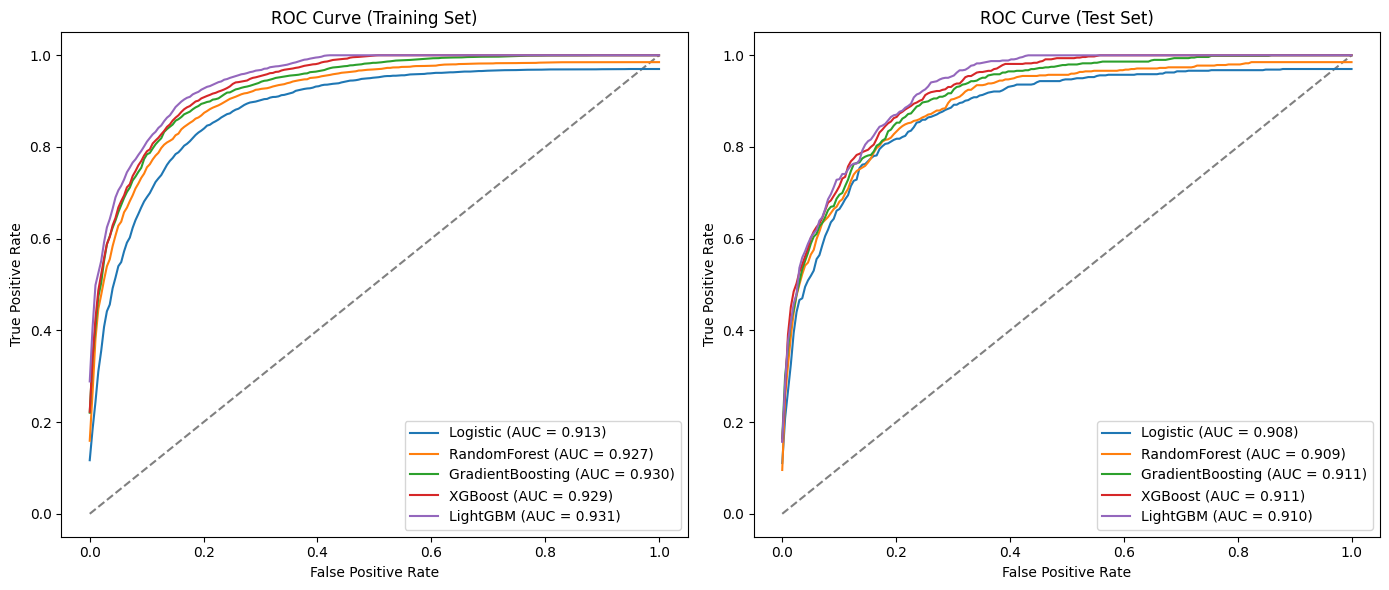

✅ 儲存 performance 指標完成


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score,
    recall_score, precision_score, f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from google.colab import files

# Set random seed for reproducibility
RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)

# Define variable groups
ordinal_vars = [
    'charity_participation_x', 'community_improvement_x', 'volunteer_work_x', 'community_meetings_x',
    'social_issue_participation_x', 'political_activity_x', 'religious_donations_x',
    'non_religious_donations_x', 'helping_others_x', 'public_opinion_polling_x',
    'civic_expression_x', 'bmi_gp_x', 'income_x', 'educational_attainment_x'
]

nominal_vars = [
    'gender_2', 'region_2', 'region_3', 'region_4',
    'religion_2', 'religion_3', 'religion_4',
    'nearby_shops_2', 'nearby_transit_2', 'nearby_cultural_sites_2',
    'nearby_relaxation_spots_2', 'traffic_safety_2', 'crime_safety_2',
    'work_1', 'marry_1'
]

continuous_vars = [
    'age_z', 'home_return_days_z', 'health_status_z',
    'relationship_satisfaction_z', 'family_relationship_satisfaction_z',
    'loneliness_z', 'life_goal_z', 'public_welfare_commitment_z',
    'delayed_gratification_z', 'financial_anxiety_z', 'safety_anxiety_z'
]

# Construct dataset
X_all = merged_data[ordinal_vars + nominal_vars + continuous_vars]
y = merged_data['SWB_category_y']

# Prepare encodings for LightGBM and other models
X_lgb = X_all.copy()
X_lgb[ordinal_vars] = X_lgb[ordinal_vars].astype('category')
X_lgb[nominal_vars] = X_lgb[nominal_vars].astype('category')

X_encoded = X_all.copy()
X_encoded[ordinal_vars] = X_encoded[ordinal_vars].astype(int)

# Train-test split
X_train_enc, X_test_enc, y_train_enc, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)
X_train_lgb, X_test_lgb, y_train_lgb, _ = train_test_split(
    X_lgb, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# Apply SMOTE to address class imbalance
X_train_enc, y_train_enc = SMOTE(sampling_strategy=0.8, random_state=RANDOM_SEED).fit_resample(X_train_enc, y_train_enc)
X_train_lgb, y_train_lgb = SMOTE(sampling_strategy=0.8, random_state=RANDOM_SEED).fit_resample(X_train_lgb, y_train_lgb)

# Model definitions
models = {
    "Logistic": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=RANDOM_SEED),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, random_state=RANDOM_SEED),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.02, max_depth=4, min_child_weight=3, gamma=0.2, subsample=0.7, colsample_bytree=0.7, random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=RANDOM_SEED)
}

# Train models
for name, model in models.items():
    if name == "LightGBM":
        model.fit(X_train_lgb, y_train_lgb)
    else:
        model.fit(X_train_enc, y_train_enc)

# Fairness evaluation using AIF360
fairness_results = []
sensitive_attributes = ['gender_2', 'income_x', 'educational_attainment_x']
label_name = 'SWB_category_y'

for attr in sensitive_attributes:
    for name, model in models.items():
        if name == "LightGBM":
            y_prob = model.predict_proba(X_test_lgb)[:, 1]
            X_temp = X_test_lgb.copy()
        else:
            y_prob = model.predict_proba(X_test_enc)[:, 1]
            X_temp = X_test_enc.copy()

        y_true = y_test.reset_index(drop=True)
        X_temp[label_name] = y_true
        X_temp['score'] = y_prob
        X_temp['pred'] = (y_prob >= 0.5).astype(int)
        X_temp = X_temp.dropna()

        if attr not in X_temp.columns:
            continue

        aif_true = BinaryLabelDataset(
            df=X_temp,
            label_names=[label_name],
            protected_attribute_names=[attr],
            favorable_label=1,
            unfavorable_label=0
        )

        aif_pred = aif_true.copy()
        aif_pred.labels = X_temp['pred'].values.reshape(-1, 1)

        metric = ClassificationMetric(
            aif_true, aif_pred,
            unprivileged_groups=[{attr: 0}],
            privileged_groups=[{attr: 1}]
        )

        fairness_results.append({
            "Model": name,
            "Sensitive Attr": attr,
            "Disparate Impact (Before)": metric.disparate_impact(),
            "Equal Opportunity (Before)": metric.equal_opportunity_difference(),
            "Equalized Odds (Before)": metric.equalized_odds_difference()
        })

fairness_df = pd.DataFrame(fairness_results)
fairness_df.to_csv("fairness_metrics_before.csv", index=False)
print("Saved fairness metrics before adjustment.")

# ROC curve visualization
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
all_fpr = np.linspace(0, 1, 200)
colors = plt.get_cmap("tab10")
offset = 0.015

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("ROC Curve (Training Set)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

for i, (name, model) in enumerate(models.items()):
    mean_tpr = np.zeros_like(all_fpr)
    auc_scores = []

    for train_idx, val_idx in kf.split(X_train_enc, y_train_enc):
        if name == "LightGBM":
            model.fit(X_train_lgb.iloc[train_idx], y_train_lgb.iloc[train_idx])
            y_pred_prob = model.predict_proba(X_train_lgb.iloc[val_idx])[:, 1]
            fpr, tpr, _ = roc_curve(y_train_lgb.iloc[val_idx], y_pred_prob)
        else:
            model.fit(X_train_enc.iloc[train_idx], y_train_enc.iloc[train_idx])
            y_pred_prob = model.predict_proba(X_train_enc.iloc[val_idx])[:, 1]
            fpr, tpr, _ = roc_curve(y_train_enc.iloc[val_idx], y_pred_prob)

        auc_scores.append(auc(fpr, tpr))
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    mean_tpr /= kf.get_n_splits()
    mean_auc = np.mean(auc_scores)
    plt.plot(all_fpr, np.clip(mean_tpr + (i - 2) * offset, 0, 1), label=f"{name} (AUC = {mean_auc:.3f})", color=colors(i))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("ROC Curve (Test Set)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

for i, (name, model) in enumerate(models.items()):
    if name == "LightGBM":
        y_pred_prob = model.predict_proba(X_test_lgb)[:, 1]
    else:
        y_pred_prob = model.predict_proba(X_test_enc)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(all_fpr, np.clip(np.interp(all_fpr, fpr, tpr) + (i - 2) * offset, 0, 1), label=f"{name} (AUC = {auc(fpr, tpr):.3f})", color=colors(i))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate model performance
metrics = {
    "Model": [], "Accuracy": [], "Sensitivity (Recall)": [],
    "Specificity": [], "Precision": [], "F1 Score": [], "AUROC": []
}

for name, model in models.items():
    if name == "LightGBM":
        y_pred = model.predict(X_test_lgb)
        y_prob = model.predict_proba(X_test_lgb)[:, 1]
    else:
        y_pred = model.predict(X_test_enc)
        y_prob = model.predict_proba(X_test_enc)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Sensitivity (Recall)"].append(recall_score(y_test, y_pred))
    metrics["Specificity"].append(tn / (tn + fp))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["F1 Score"].append(f1_score(y_test, y_pred))
    metrics["AUROC"].append(roc_auc_score(y_test, y_prob))

performance_df = pd.DataFrame(metrics)
performance_df.to_csv("final_model_performance.csv", index=False)
print("Saved final model performance metrics.")

# Trigger file download (Colab only)
files.download("final_model_performance.csv")
files.download("fairness_metrics_before.csv")


####SHAP

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
<ipython-input-34-f234ef636c99>:86: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)


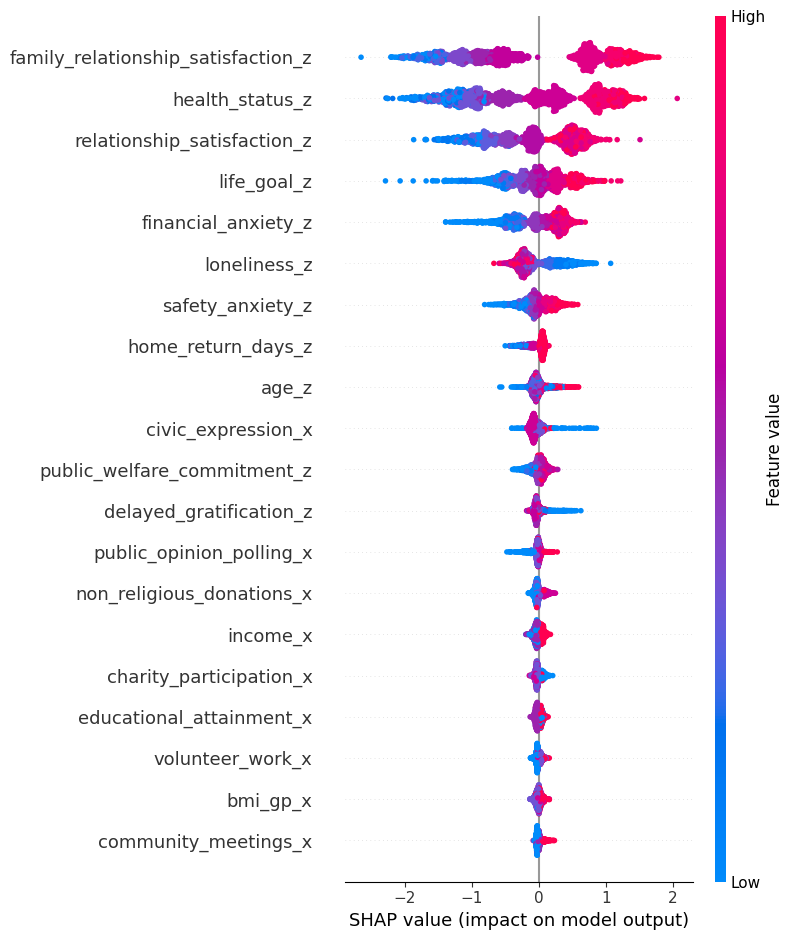

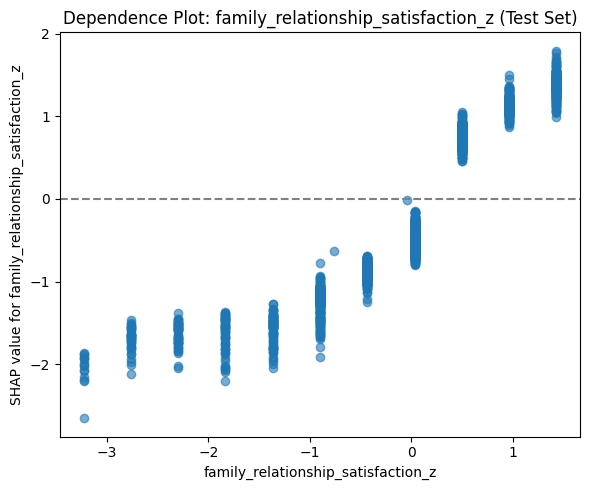

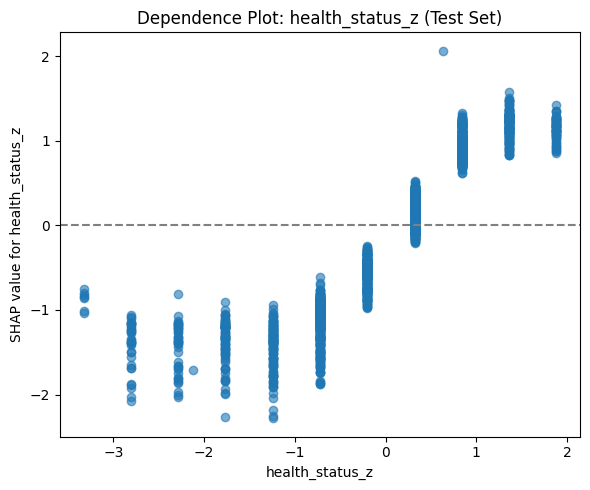

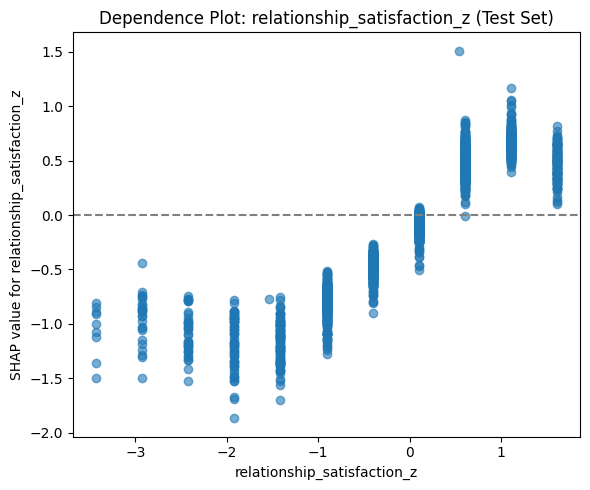

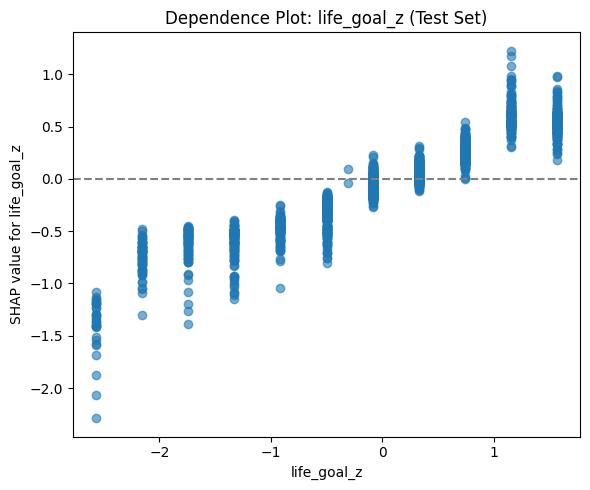

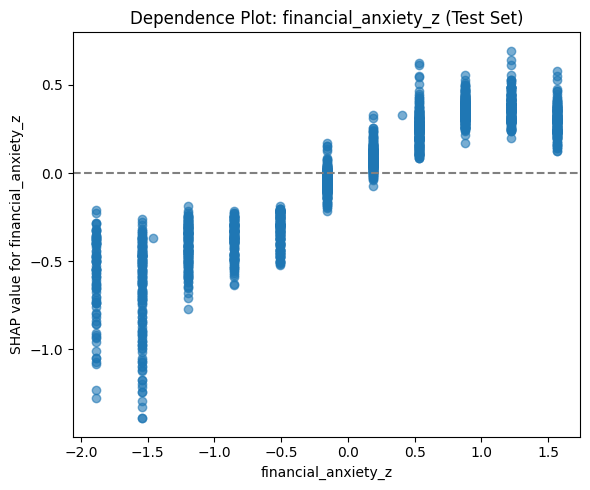

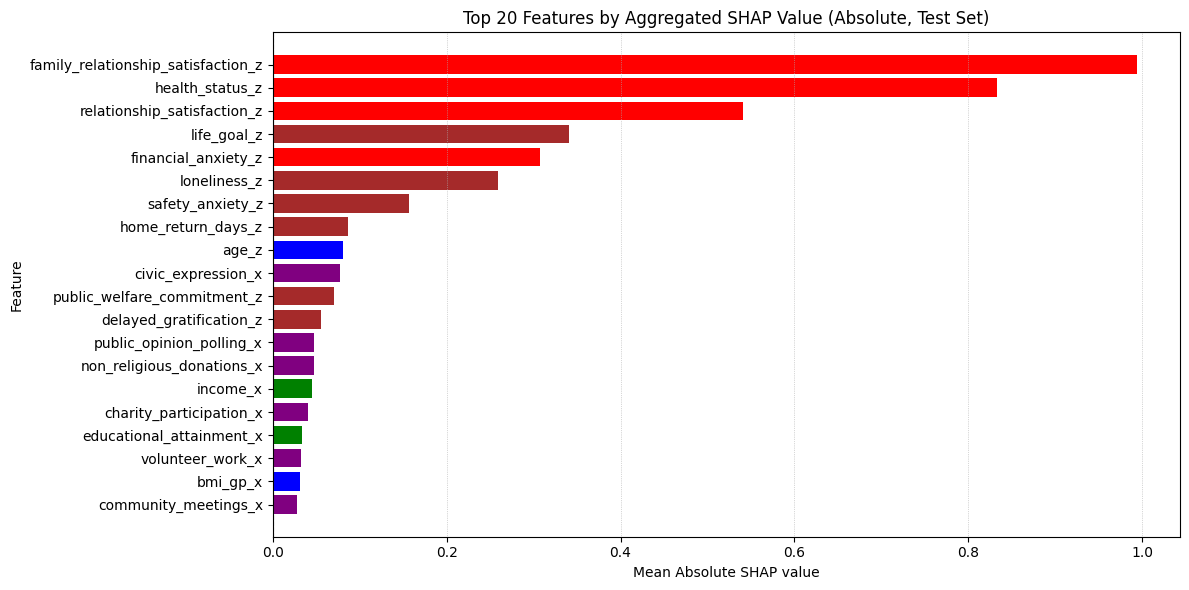

⚠️ 以下變項沒有分類（所以顯示為灰色）：



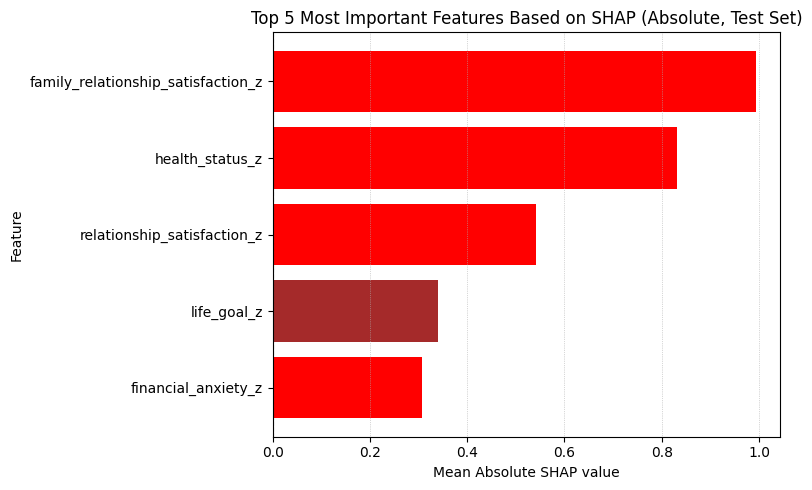

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# Define category color mapping for feature grouping
category_colors = {
    'Demographic Variables': 'blue',
    'Socioeconomic Variables': 'green',
    'Neighborhood Environment Variables': 'orange',
    'Social Participation Variables': 'purple',
    'Health and Satisfaction Variables': 'red',
    'Psychological and Behavioral Variables': 'brown'
}

# Define feature categories (updated to match full variable list)
categories = {
    'Demographic Variables': [
        'gender', 'region', 'religion_2', 'religion_3', 'religion_4', 'age_z', 'marry', 'bmi_gp_x'
    ],
    'Socioeconomic Variables': [
        'work', 'work_1', 'income_x', 'educational_attainment_x'
    ],
    'Neighborhood Environment Variables': [
        'nearby_shops_2', 'nearby_relaxation_spots', 'traffic_safety_2',
        'crime_safety_2', 'nearby_cultural_sites', 'nearby_cultural_sites_2'
    ],
    'Social Participation Variables': [
        'charity_participation_x', 'community_improvement_x', 'volunteer_work_x',
        'community_meetings_x', 'social_issue_participation_x', 'political_activity_x',
        'religious_donations_x', 'non_religious_donations_x', 'helping_others_x',
        'public_opinion_polling_x', 'civic_expression_x'
    ],
    'Health and Satisfaction Variables': [
        'health_status_z', 'relationship_satisfaction_z', 'financial_anxiety_z',
        'family_relationship_satisfaction_z'
    ],
    'Psychological and Behavioral Variables': [
        'public_welfare_commitment_z', 'delayed_gratification_z',
        'safety_anxiety_z', 'life_goal_z', 'home_return_days_z', 'loneliness_z'
    ]
}

# SHAP analysis using TreeExplainer for LightGBM model
Baseline_LightGBM = models["LightGBM"]
explainer = shap.TreeExplainer(Baseline_LightGBM)
shap_values = explainer.shap_values(X_test_lgb)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification

# Convert categorical variables to numeric codes for SHAP visualization
X_test_numeric = X_test_lgb.copy()
for col in X_test_numeric.select_dtypes(include='category').columns:
    X_test_numeric[col] = X_test_numeric[col].cat.codes

# SHAP aggregation function for grouped features
def aggregate_shap(shap_vals, X, feature_names, method="signed"):
    shap_df = pd.DataFrame(shap_vals, columns=feature_names)
    X_df = pd.DataFrame(X, columns=feature_names)
    base_features = {}
    for col in feature_names:
        base = re.sub(r"_\d+$", "", col)
        base_features.setdefault(base, []).append(col)

    aggregated_shap = pd.DataFrame()
    aggregated_features = pd.DataFrame()
    for base, cols in base_features.items():
        if method == "abs":
            aggregated_shap[base] = shap_df[cols].abs().mean(axis=1)
        else:
            aggregated_shap[base] = shap_df[cols].mean(axis=1)
        aggregated_features[base] = X_df[cols].mean(axis=1)

    return aggregated_shap, aggregated_features

# Aggregate SHAP values for the test set
shap_df_signed, X_df_signed = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="signed")

# SHAP summary plot (Top 20)
shap.summary_plot(shap_df_signed.values, X_df_signed, feature_names=shap_df_signed.columns, max_display=20)

# SHAP dependence plots for top 5 features
top5_signed = shap_df_signed.abs().mean().sort_values(ascending=False).head(5).index.tolist()
for feature in top5_signed:
    plt.figure(figsize=(6, 5))
    plt.scatter(X_df_signed[feature], shap_df_signed[feature], alpha=0.6)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel(feature)
    plt.ylabel(f"SHAP value for {feature}")
    plt.title(f"Dependence Plot: {feature} (Test Set)")
    plt.tight_layout()
    plt.show()

# Assign color by feature group
def get_feature_color(f):
    for cat, vars in categories.items():
        if f in vars:
            return category_colors[cat]
    return 'gray'  # Default color if feature is not categorized

# SHAP bar chart: Top 20 features (by mean absolute value)
shap_df_abs, _ = aggregate_shap(shap_values, X_test_numeric, X_test_numeric.columns, method="abs")
mean_abs_vals = shap_df_abs.mean().sort_values(ascending=False).head(20)

colors = [get_feature_color(f) for f in mean_abs_vals.index]

plt.figure(figsize=(12, 6))
plt.barh(mean_abs_vals.index[::-1], mean_abs_vals.values[::-1], color=colors[::-1])
plt.xlabel("Mean Absolute SHAP value")
plt.ylabel("Feature")
plt.title("Top 20 Features by Aggregated SHAP Value (Absolute, Test Set)")
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# Identify uncategorized features
uncategorized_features = [f for f in mean_abs_vals.index if get_feature_color(f) == 'gray']
print("Uncategorized features (shown in gray):")
for f in uncategorized_features:
    print(f"- {f}")

# SHAP bar chart: Top 5 features (absolute value)
mean_abs_vals_top5 = mean_abs_vals.head(5)

plt.figure(figsize=(8, 5))
plt.barh(mean_abs_vals_top5.index[::-1], mean_abs_vals_top5.values[::-1],
         color=[get_feature_color(f) for f in mean_abs_vals_top5.index[::-1]])
plt.xlabel("Mean Absolute SHAP value")
plt.ylabel("Feature")
plt.title("Top 5 Most Important Features Based on SHAP (Absolute, Test Set)")
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()
